In [7]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os, sys
# Add the function directory to the path
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/')
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/project_specific/windwave/')
# sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
# sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/project_specific/windwave/')
from fio import readin
from tqdm import tqdm
"""Use customized plotting theme"""
import matplotlib as mpl
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/jfm.mplstyle')
from matplotlib.ticker import FuncFormatter, MultipleLocator
# mpl.get_configdir() # Can't seem to set the MPLCONFIGDIR on tiger
# mpl.style.use('pof')

In [2]:
from prepare import load_object, save_object
from defs import Case, Interface2D

### Read-in interface and append (the whole object)
#### Either from scratch or load case

In [5]:
"""First read in data as it is."""

def read_eta (case):
    case.Ep = []; case.Erms = []
    case.interface = [] # Sampling interface (full information)
    case.tau0 = case.rho2*case.ustar**2
    for t in tqdm(case.tsimu):
        interface = Interface2D(L0 = case.L0, N = case.N, 
                                path = case.path, pre='eta/eta_loc_t', t = t, PRUNING=True)
        interface.spectrum(peak = 4)
        interface.stress(case.tau0, case.mu2)
        case.interface.append(interface)
        case.Ep.append(interface.Ep)
        case.Erms.append(np.std(interface.eta)**2)
    case.Ep = np.array(case.Ep); case.Erms = np.array(case.Erms)
    case.t = np.array(case.tsimu-case.tstart) # Actual time from when the wave started

In [27]:
version = '_tiger'

case = case1
case.tsimu = np.arange(58,108) # Simulation time
print(case.tsimu)
picklename = case.path + 'case' + version + '.pkl'
case1 = load_object(picklename)
case1.t = case1.tsimu - case1.tstart
# # read_eta (case)

case = case2
case.tsimu = np.arange(58,103) 
print(case.tsimu)
picklename = case.path + 'case' + version + '.pkl'
case2 = load_object(picklename)
case2.t = case2.tsimu - case2.tstart
# # read_eta (case)

# case = case3
# case.tsimu = np.arange(58,73) 
# print(case.tsimu)
# picklename = case.path + 'case' + version + '.pkl'
# case3 = load_object(picklename)
# case3.t = case3.tsimu - case3.tstart

# case = case4
# case.tsimu = np.arange(308,346) # Simulation time
# version = '_tiger'
# picklename = case.path + 'case' + version + '.pkl'
# case4 = load_object(picklename)

# case = case5
# case.tsimu = np.arange(302,342) # Simulation time
# version = '_tiger'
# picklename = case.path + 'case' + version + '.pkl'
# case5 = load_object(picklename)

# case = case6
# case.tsimu = np.arange(308,320) # Simulation time
# version = '_tiger'
# picklename = case.path + 'case' + version + '.pkl'
# case6 = load_object(picklename)

[ 58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107]
[ 58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102]


In [ ]:
""" Pickle """
case = case11
case.tsimu = np.arange(44,56,1)
print(case.tsimu)
case.t = case.tsimu - case.tstart
read_eta (case)
version = '_tiger'
picklename = case.path + 'case' + version + '.pkl'
save_object(case, picklename)

In [63]:
# List comprehension
""" Compute the stress time sequence """
case = case6
for j in range(0, np.size(case.t)):
    case.interface[j].stress(case.tau0,case.mu2)
formdrag_all = [interface.formdrag for interface in case.interface]
shear_all = [interface.shear for interface in case.interface]
p1d_all = [np.roll(np.average(interface.p/case.tau0, axis=0), -(interface.idx), axis=0) for interface in case.interface]
idx = [interface.idx for interface in case.interface]

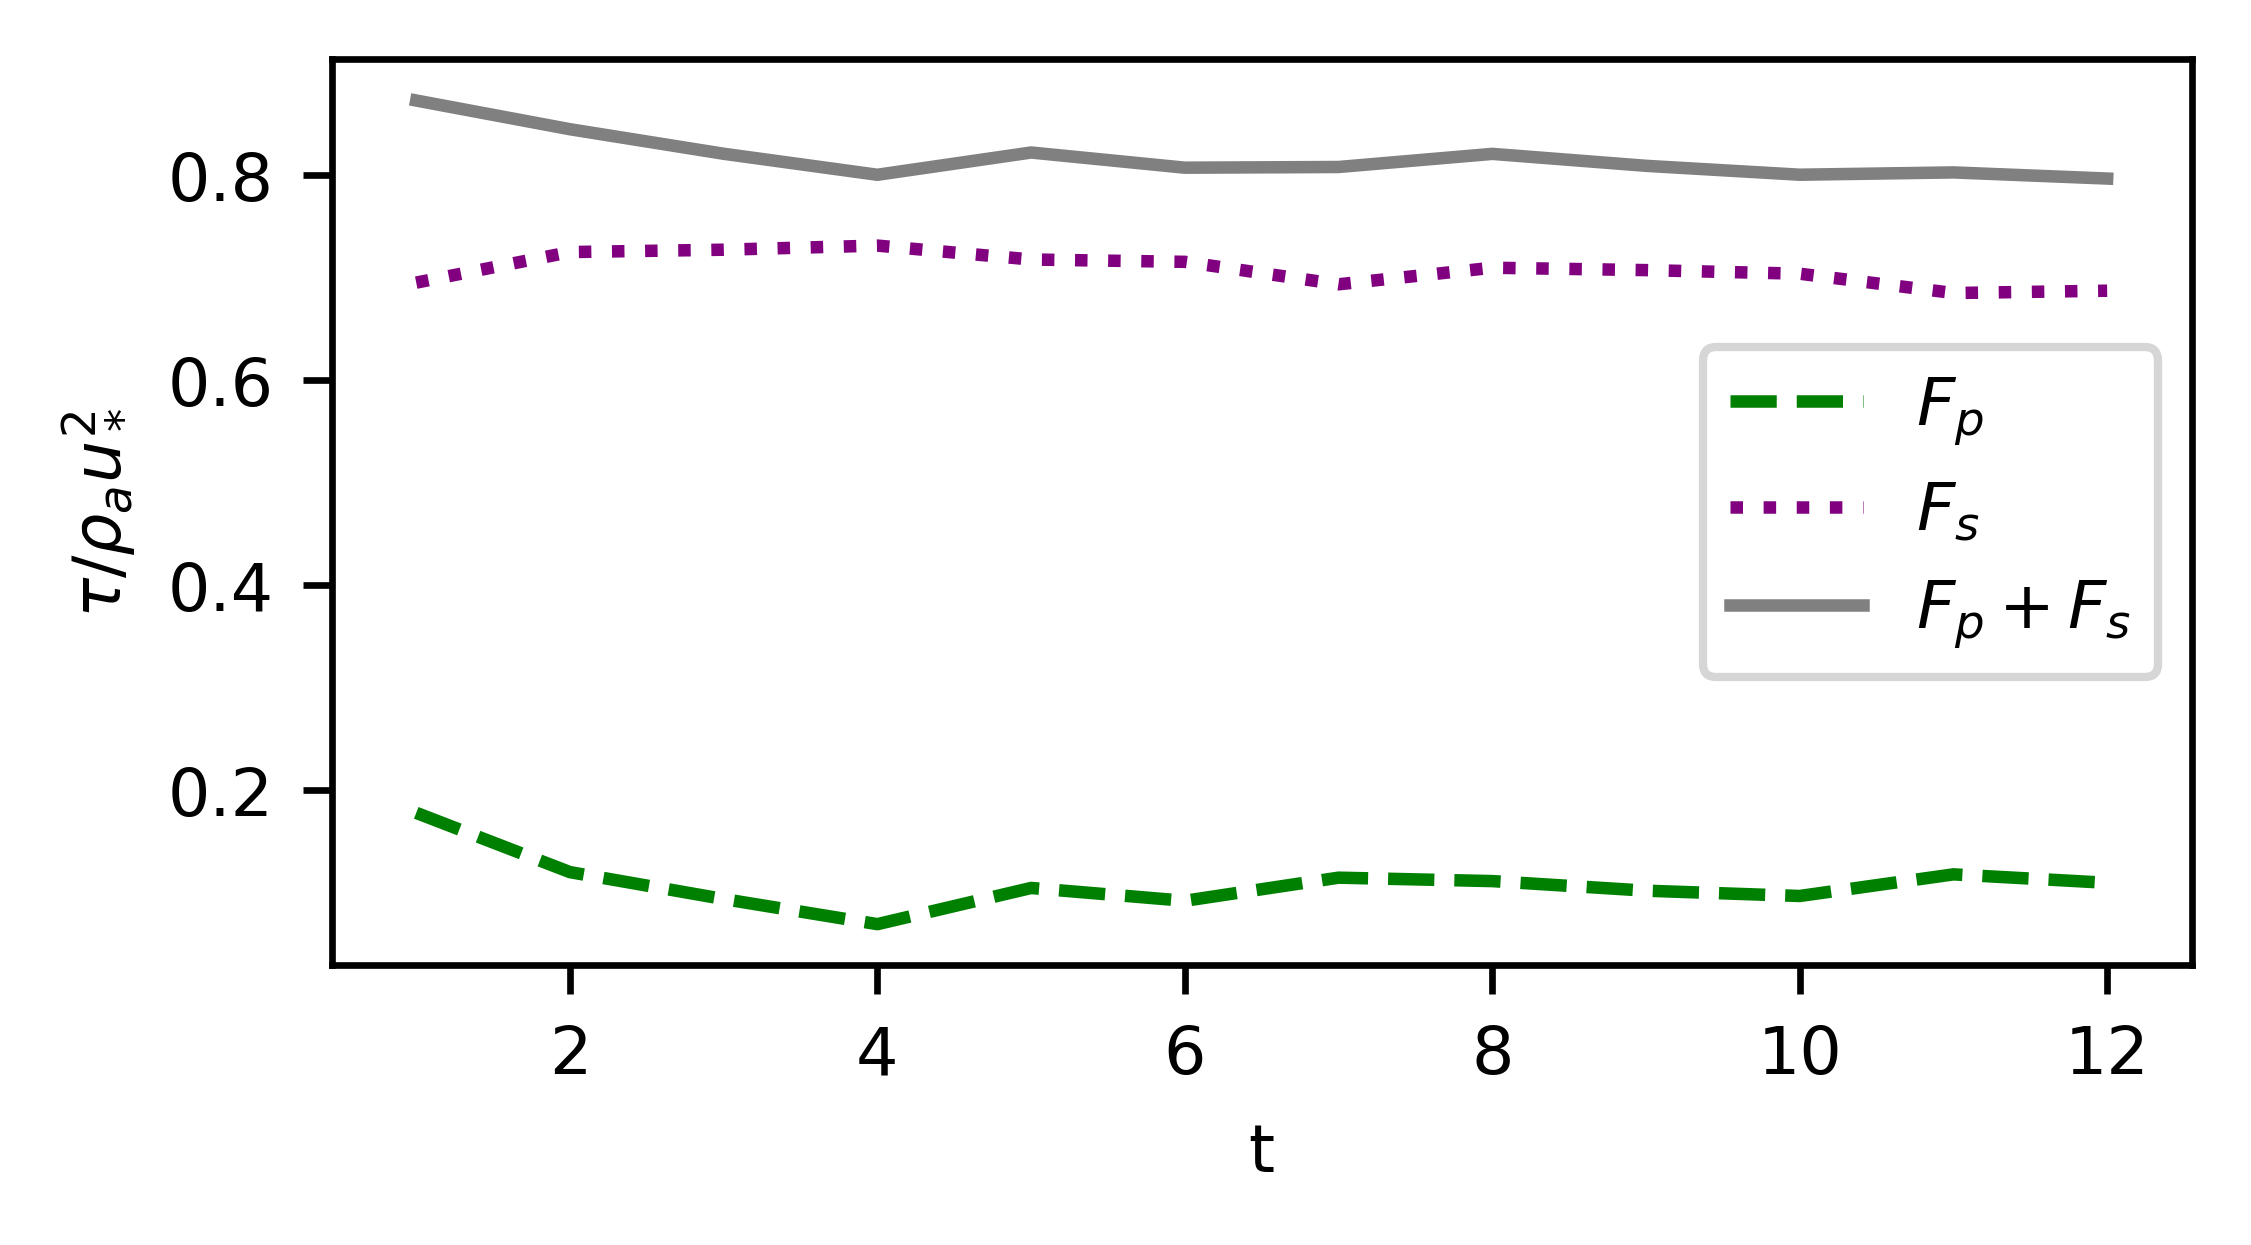

In [74]:
plt.figure(figsize=[4,2])
plt.plot(case.t, np.array(formdrag_all)/case.tau0, '--', c='green', label='$F_p$')
plt.plot(case.t, np.array(shear_all)/case.tau0, ':', c='purple', label='$F_s$')
plt.plot(case.t, (np.array(shear_all)+np.array(formdrag_all))/case.tau0, 'gray', label='$F_p+F_s$')
plt.xlabel('t')
plt.ylabel(r'$\tau/\rho_a u_*^2$')
plt.legend()

In [ ]:
"""Read in a time series of eta_loc (might get the warning that 'Columns (0,1,2,3,4,5,6,7,8) have mixed types'
because the files are concatenated from different pids)."""
case = case2
tau0 = case.rho2*case.ustar**2
mu_a = case.mu2; rho_a = case.rho2
nu_a = mu_a/rho_a
case.formdrag = []; case.shear = []; case.eta1D = []; case.energy = []
case.t = []
for i in range(1,16):
    t = 57+i
    case.t.append(i)
    interface = Interface2D(L0 = 2*np.pi, N = 512, 
                            path = case.path, pre='eta/eta_loc_t', t = t, PRUNING=True)
    interface.stress(tau0, mu_a)
    case.formdrag.append(interface.formdrag); case.shear.append(interface.shear)
    """Energy (rms)"""
    energy = np.sum((interface.eta-np.average(interface.eta))**2)
    case.energy.append(energy)
    """Eta 1D"""
    case.eta1D.append(np.average(interface.eta, axis=0))
    print(t, interface.formdrag, interface.shear)

In [ ]:
"""Read in a time series of eta_loc (might get the warning that 'Columns (0,1,2,3,4,5,6,7,8) have mixed types'
because the files are concatenated from different pids)."""
case = case1
tau0 = case.rho2*case.ustar**2
mu_a = case.mu2; rho_a = case.rho2
nu_a = mu_a/rho_a
case.formdrag = []; case.shear = []; case.eta1D = []; case.energy = []
case.t = []
for i in range(1,58):
    t = 57+i*0.5
    case.t.append(i*0.5)
    interface = Interface2D(L0 = 2*np.pi, N = 512, 
                            path = case.path, pre='eta/eta_loc_t', t = t, PRUNING=True)
    interface.stress(tau0, mu_a)
    case.formdrag.append(interface.formdrag); case.shear.append(interface.shear)
    """Energy (rms)"""
    energy = np.sum((interface.eta-np.average(interface.eta))**2)
    case.energy.append(energy)
    """Eta 1D"""
    case.eta1D.append(np.average(interface.eta, axis=0))
    print(t, interface.formdrag, interface.shear)

In [ ]:
"""Phase average the pressure"""
case = case2
tau0 = case.rho2*case.ustar**2
mu_a = case.mu2; rho_a = case.rho2
nu_a = mu_a/rho_a
p1d_shift_ensem = []; tau1d_shift_ensem = []
case.t = []
for i in range(5,10):
    t = 60+i*1
    case.t.append(t)
    interface = Interface2D(L0=2*np.pi, N=512, 
                            path=case.path, pre='eta/eta_loc_t', t=t, PRUNING=True)    
    interface.stress(tau0, mu_a)
    p1d = np.average(interface.p/tau0, axis=0)
    p1d_shift = np.roll(p1d, -(interface.idx), axis=0)
    p1d_shift_ensem.append(p1d_shift)
    tau1d = np.average(interface.tau_nux/tau0, axis=0)
    tau1d_shift = np.roll(tau1d, -(interface.idx), axis=0)
    tau1d_shift_ensem.append(tau1d_shift)

p1d_phase_aver = np.average(p1d_shift_ensem, axis=0)
tau1d_phase_aver = np.average(tau1d_shift_ensem, axis=0)

In [ ]:
"""Visualization of averaged pressure and shear stress."""
fig = plt.figure(figsize=[6,3])
L0 = 2*np.pi; N =512
eta_1D_filtered = np.roll(np.average(interface.eta, axis=0), -(interface.idx), axis=0)
deta_dx = np.roll(np.average(interface.grad, axis=0), -(interface.idx), axis=0)
r1 = 0
r2 = 512
plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), (eta_1D_filtered-1)[r1:r2]*4, alpha=0.5, label=r'$\eta(x)k $', color='gray')
plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), deta_dx[r1:r2]*4, '--', alpha=0.5, label=r'$d\eta(x)/dx $', color='gray')
plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), p1d_phase_aver[r1:r2]/5, label=r'$p_s/5\rho_{a}u_*^2$', color=plt.cm.tab20(1)) 
# plt.plot(interface.xarray/(2*np.pi/4), p1d_geo, label=r'$p_s(\partial \eta/ \partial x)/\rho_{a}u_*^2$', color=plt.cm.tab20(0)) 
plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), tau1d_phase_aver[r1:r2], label=r'$\tau_{\nu x}/\rho_{a}u_*^2$', color=plt.cm.tab20(2))

"""Find the phase difference"""
# from scipy.signal import argrelextrema
# maxm1 = argrelextrema(p1d_phase_aver[r1:r2], np.greater)  # (array([1, 3, 6]),)
# maxm2 = argrelextrema(eta_1D_filtered[r1:r2], np.greater)  # (array([1, 3, 6]),)
# x1 = np.ones(20)*(interface.xarray[r1:r2][maxm1[0][5]])/(2*np.pi/4)
x1 = np.ones(20)*(-1.2)
y1= np.linspace(1.4,2.1,20)
plt.plot(x1,y1,'--', color='k',lw=1)
# x2 = np.ones(20)*(interface.xarray[r1:r2][maxm1[0][7]])/(2*np.pi/4)
x2 = np.ones(20)*(-1)
y2= np.linspace(0.5,2.1,20)
plt.plot(x2,y2,'--', color='k',lw=1)
plt.text(-1.15, 1.8, r'$\Delta\phi$')

plt.ylim([-2,4])
plt.xlim([-2,2])
# plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.legend(loc = 'upper right')
plt.xlabel(r'$xk$')
t = (np.array(case.t)-57)/(2*np.pi/case.wave.omega)
plt.title(r"$t=%.1f-%.1fT, u_*/c=%.2f$" %(t[0], t[-1], (case.ustar/case.wave.c)))

In [ ]:
fig = plt.figure(figsize=[6,2])
L0 = 2*np.pi; N =512
eta_1D_filtered = np.roll(np.average(interface.eta, axis=0), -(interface.idx), axis=0)
deta_dx = np.roll(np.average(interface.grad, axis=0), -(interface.idx), axis=0)
r1 = 0
r2 = 512
case.tstart = 57

plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), (eta_1D_filtered-1)[r1:r2]*4, alpha=0.5, label=r'$\eta(x)k $', color='gray')
plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), deta_dx[r1:r2]*4, '--', alpha=0.5, label=r'$d\eta(x)/dx $', color='gray')
for (i,p1d) in enumerate(p1d_phase_aver):
    if i == 0 or i == 18:
        plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), p1d[r1:r2]/5, label=r'$p_s/5\rho_{a}u_*^2, t = %.1fT$' %((case.t[i]-case.tstart)*case.wave.omega/(2*np.pi)), 
                 color=plt.cm.get_cmap('summer')(1-i/20), alpha = 0.5)
    else:
        plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), p1d[r1:r2]/5,
                 color=plt.cm.get_cmap('summer')(1-i/20), alpha = 0.5) 
# for (i,tau1d) in enumerate(tau1d_phase_aver):
#     plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), tau1d[r1:r2], label=r'$\tau_{\nu x}/\rho_{a}u_*^2$', color=plt.cm.get_cmap('summer')(1-i/5))

"""Find the phase difference"""
# from scipy.signal import argrelextrema
# maxm1 = argrelextrema(p1d_phase_aver[r1:r2], np.greater)  # (array([1, 3, 6]),)
# maxm2 = argrelextrema(eta_1D_filtered[r1:r2], np.greater)  # (array([1, 3, 6]),)
# x1 = np.ones(20)*(interface.xarray[r1:r2][maxm1[0][5]])/(2*np.pi/4)
x1 = np.ones(20)*(-1.2)
y1= np.linspace(1.4,2.1,20)
plt.plot(x1,y1,'--', color='k',lw=1)
# x2 = np.ones(20)*(interface.xarray[r1:r2][maxm1[0][7]])/(2*np.pi/4)
x2 = np.ones(20)*(-1)
y2= np.linspace(0.5,2.1,20)
plt.plot(x2,y2,'--', color='k',lw=1)
plt.text(-1.15, 1.8, r'$\Delta\phi$')

plt.ylim([-2,4])
plt.xlim([-2,2])
# plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.legend(loc = 'upper right')
plt.xlabel(r'$xk$')
t = (np.array(case.t)-57)/(2*np.pi/case.wave.omega)
plt.title(r"$t=%.1f-%.1fT, u_*/c=%.2f$" %(t[0], t[-1], (case.ustar/case.wave.c)))

In [126]:
"""Verify the pressure forcing theory"""
Fp = np.average(p1d_phase_aver[r1:r2]*deta_dx[r1:r2])
print(Fp)
beta_fromp = 2*np.pi*1/850*(0.25)**2*2*Fp/0.2**2
print(beta_fromp)
# beta = T/E*(dE/dt) = 0.037/0.008

0.42739513570466536
0.009872804547866097


In [115]:
Fp = np.average(p1d_phase_aver[r1:r2]*deta_dx[r1:r2])
print(Fp)
beta_fromp = 2*np.pi*1/850*(0.5)**2*2*Fp/0.2**2
print(beta_fromp)
# beta = T/E*(dE/dt) = 0.037/0.008

0.42990575250625696
0.03972319864146025


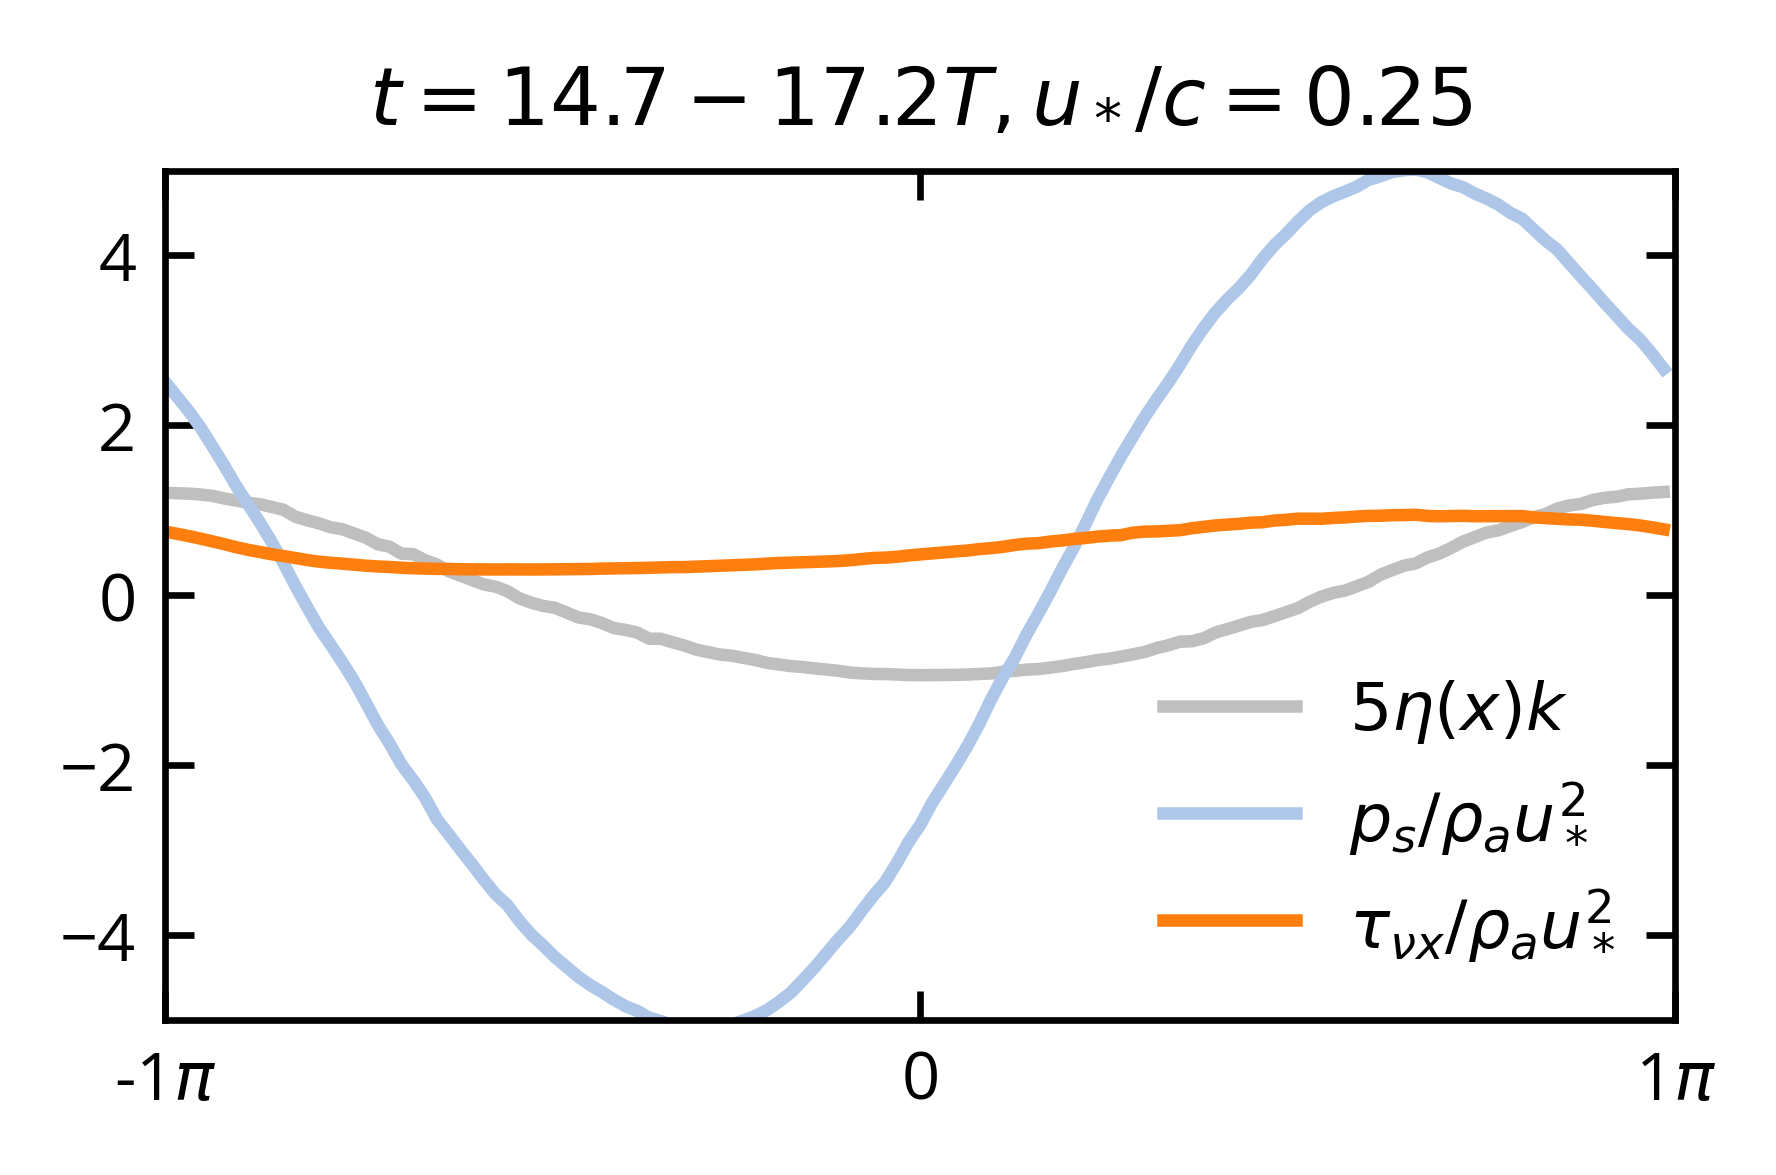

In [9]:
"""Additional averaging between the four crest"""
plt.figure(figsize=[3,2]); ax =plt.gca()
p1d_split = (p1d_phase_aver[0:128], p1d_phase_aver[128:256], p1d_phase_aver[256:384], p1d_phase_aver[384:512])
p1d_phase_aver_1 = np.average(p1d_split, axis=0)
tau1d_split = (tau1d_phase_aver[0:128], tau1d_phase_aver[128:256], tau1d_phase_aver[256:384], tau1d_phase_aver[384:512])
tau1d_phase_aver_1 = np.average(tau1d_split, axis=0)
plt.plot(interface.xarray[192:320]*4, (eta_1D_filtered-1)[0:128]*4*5, alpha=0.5, label=r'$5\eta(x)k $', color='gray')
plt.plot(interface.xarray[192:320]*4, p1d_phase_aver_1, label=r'$p_s/\rho_{a}u_*^2$', color=plt.cm.tab20(1))
plt.plot(interface.xarray[192:320]*4, tau1d_phase_aver_1, label=r'$\tau_{\nu x}/\rho_{a}u_*^2$', color=plt.cm.tab20(2)) 
plt.title(r"$t=%.1f-%.1fT, u_*/c=%.2f$" %(t[0], t[-1], (case.ustar/case.wave.c)))
plt.ylim([-5,5])
plt.xlim([-np.pi,np.pi])
plt.legend(loc='lower right')
from matplotlib.ticker import FuncFormatter, MultipleLocator
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))

'TODO: add stress from the bulk flow'

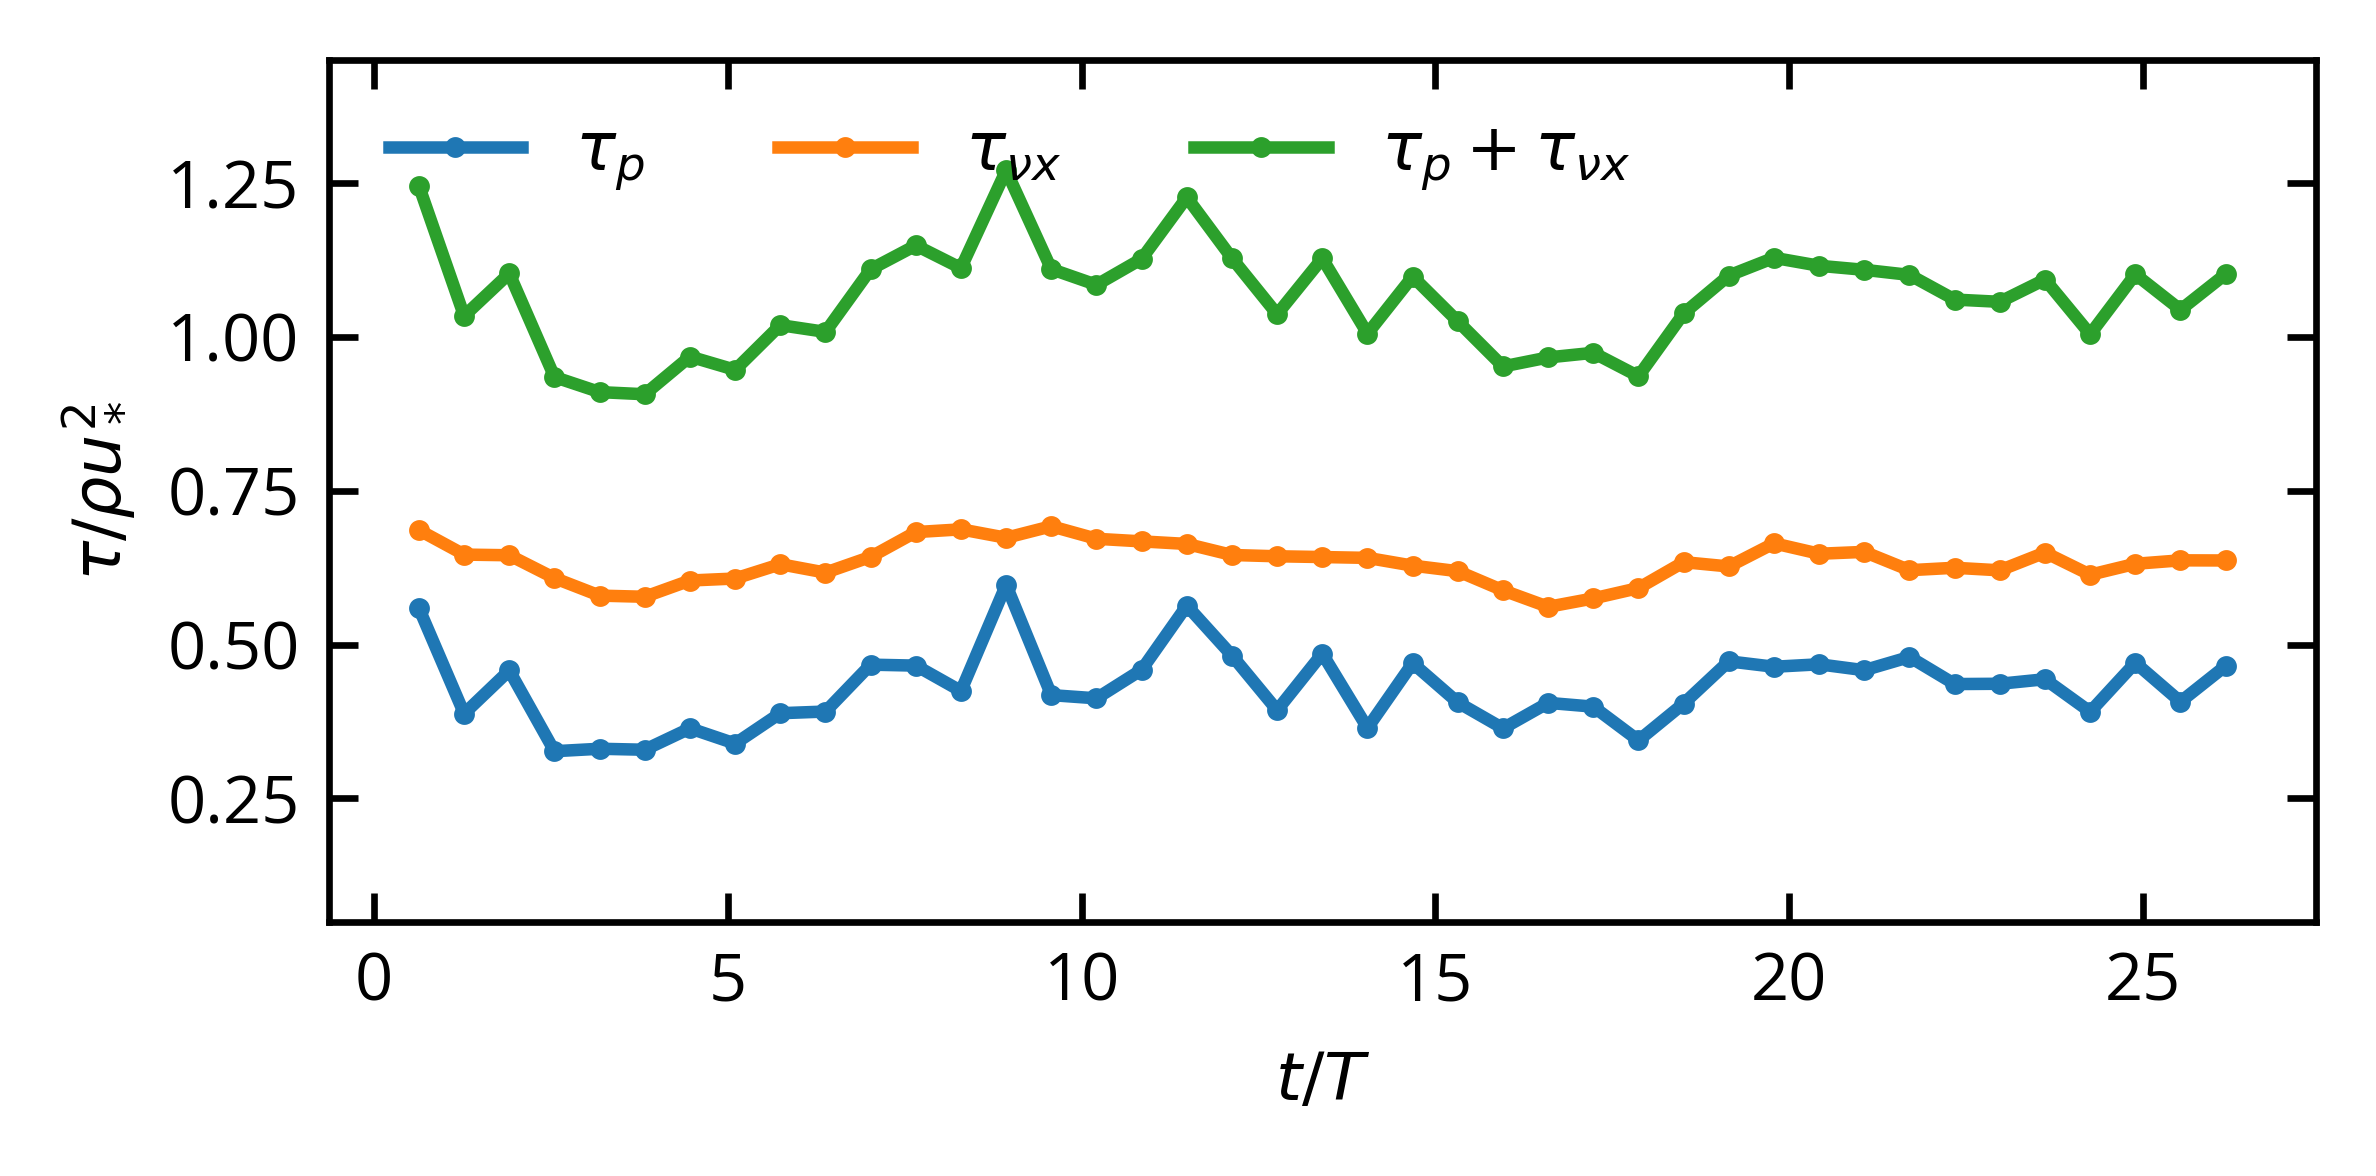

In [76]:
fig = plt.figure(figsize=[4,2])
t = np.arange(1,42)
case = case2
T = 2*np.pi/case.wave.omega 
formdrag = np.array(case.formdrag); shear = np.array(case.shear)
plt.plot(t/T, formdrag/tau0, label = r'$\tau_p$', marker='.', markersize=3)
plt.plot(t/T, shear/tau0, label = r'$\tau_{\nu x}$', marker='.', markersize=3)
plt.plot(t/T, (shear+formdrag)/tau0, label = r'$\tau_p + \tau_{\nu x}$', marker='.', markersize=3)
plt.xlabel(r'$t/T$'); plt.ylabel(r'$\tau/\rho u_*^2$')
plt.ylim([0.05,1.45])
plt.legend(loc='upper left', ncol=3)
fig.savefig('/home/jiarong/Downloads/ICTAM/stress_partition_g4.pdf')
"""TODO: add stress from the bulk flow"""

In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(interface.xdata, interface.zdata, interface.pdata-np.average(interface.pdata), c=interface.pdata, cmap='Greens')

0.3209327550488652 0.5828758052076489


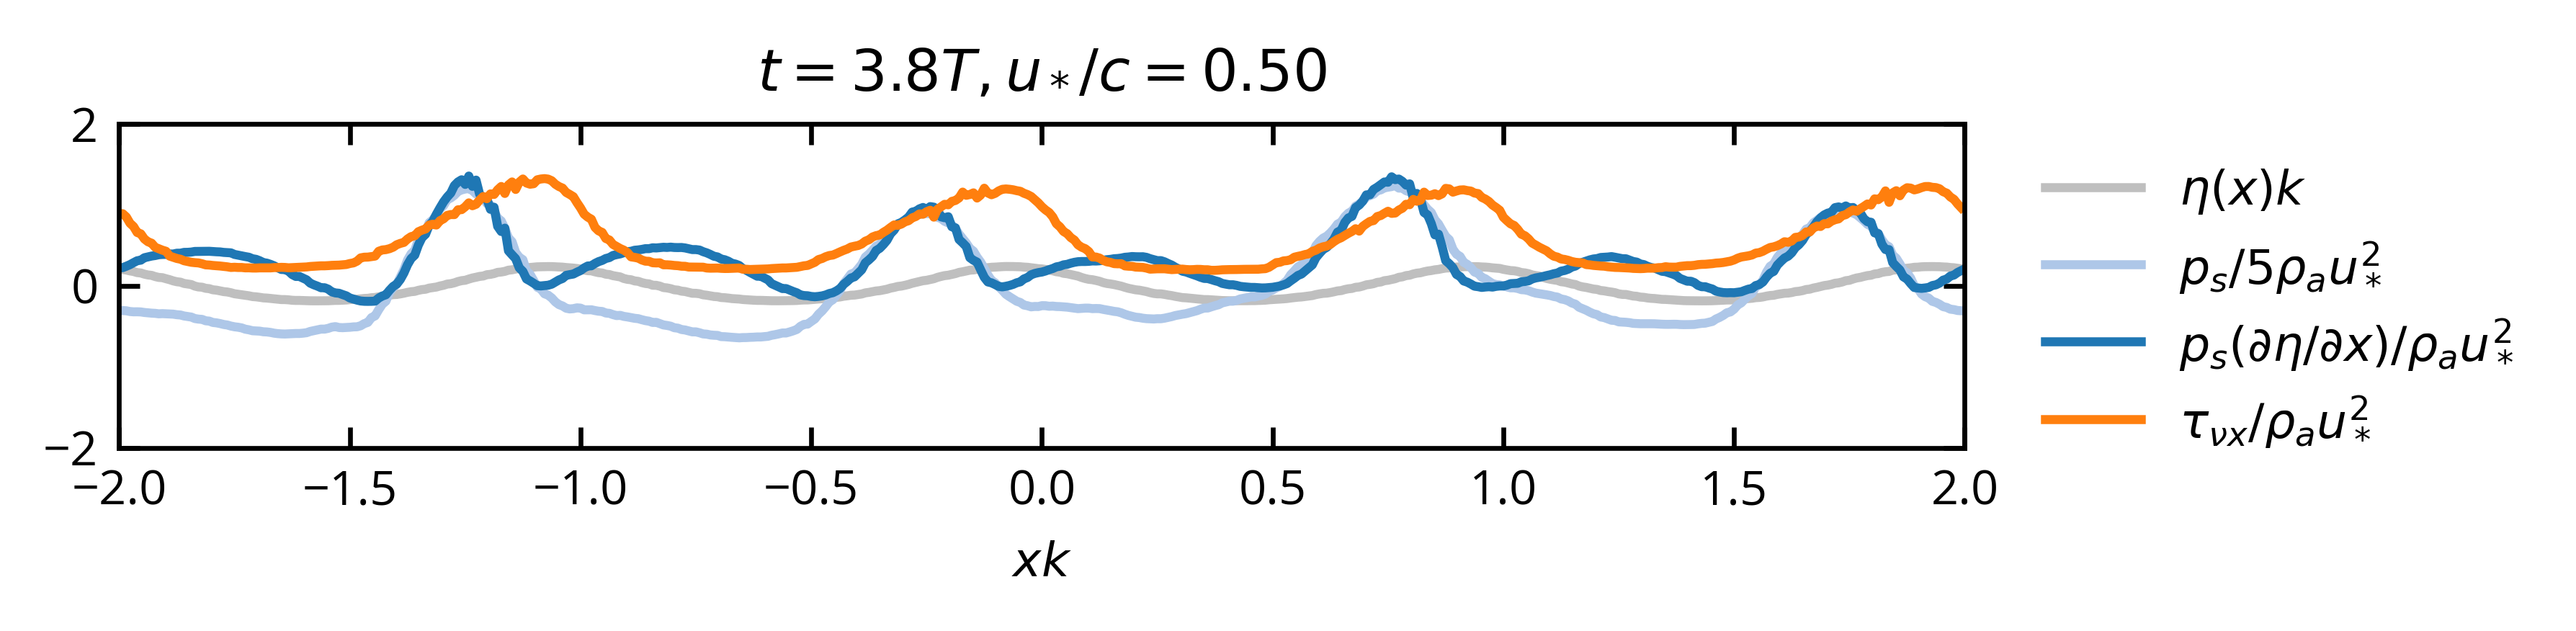

In [18]:
"""Comparison of 1D averaged stress between two methods.
Comes after the stress function was called."""

fig = plt.figure(figsize=[6,1.5])
t = 69
case = case1
tau0 = case.rho2*case.ustar**2
mu_a = case.mu2; rho_a = case.rho2
nu_a = mu_a/rho_a
interface = Interface2D(L0 = 2*np.pi, N = 512, 
                        path = case.path, 
                        pre='eta/eta_loc_t', t = t, PRUNING=True)
interface.stress(tau0, mu_a)

L0 = 2*np.pi; N =512
eta_1D_filtered = np.average(interface.eta, axis=0)
plt.plot(interface.xarray/(2*np.pi/4), (eta_1D_filtered-1)*4, alpha = 0.5, label=r'$\eta(x)k $', color = 'gray')
# plt.plot(interface.xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', alpha = 0.5, label=r'$10d\eta/dx$', color = 'gray')

# Method 1 bulk interpolation
# plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[3][0:-1]-np.average(pinterp[3][0:-1]))/(rho_a*0.25**2), 
#          label = r'$p_s/\rho_{a}u_*^2$ method 1', color = plt.cm.tab20(0))
# plt.plot(xarray[0:-1]/(2*np.pi/4), 5.*(tauv_dudy[1][0:-1])*nu_a/0.25**2, 
#          label = r'$5\tau_{\nu}/\rho_{a}u_*^2$ method 1', color = plt.cm.tab20(2))

# Method 2 probing interface
p1d = np.average(interface.p/tau0, axis = 0)
p1d_geo = np.average(interface.p*interface.grad/tau0, axis = 0)
tau1d = np.average(interface.tau_nux/tau0, axis = 0)
plt.plot(interface.xarray/(2*np.pi/4), p1d/5, label=r'$p_s/5\rho_{a}u_*^2$', color = plt.cm.tab20(1)) 
plt.plot(interface.xarray/(2*np.pi/4), p1d_geo, label=r'$p_s(\partial \eta/ \partial x)/\rho_{a}u_*^2$', color = plt.cm.tab20(0)) 
plt.plot(interface.xarray/(2*np.pi/4), tau1d, label=r'$\tau_{\nu x}/\rho_{a}u_*^2$', color = plt.cm.tab20(2))
# plt.plot(xarray/(2*np.pi/4), 5.*tau1d_extra, '--', label=r'$5\tau_{\nu}/\rho_{a}u_*^2$ method 2', color = plt.cm.tab20(3))

plt.ylim([-2,2])
plt.xlim([-2,2])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.xlabel(r'$xk$')
# plt.title(r"$t=%g, u_*/c=%g$" %(60-57, 0.25))
plt.title(r"$t=%.1fT, u_*/c=%.2f$" %((t-57)/(2*np.pi/case.wave.omega), (case.ustar/case.wave.c)))
print(interface.formdrag/tau0, interface.shear/tau0)
fig.savefig('/home/jiarong/Downloads/ICTAM/stress_alongx_g1_t12.pdf')
# fig.savefig('/home/jiarong/Downloads/ICTAM/stress_alongx_g4_t6.pdf')

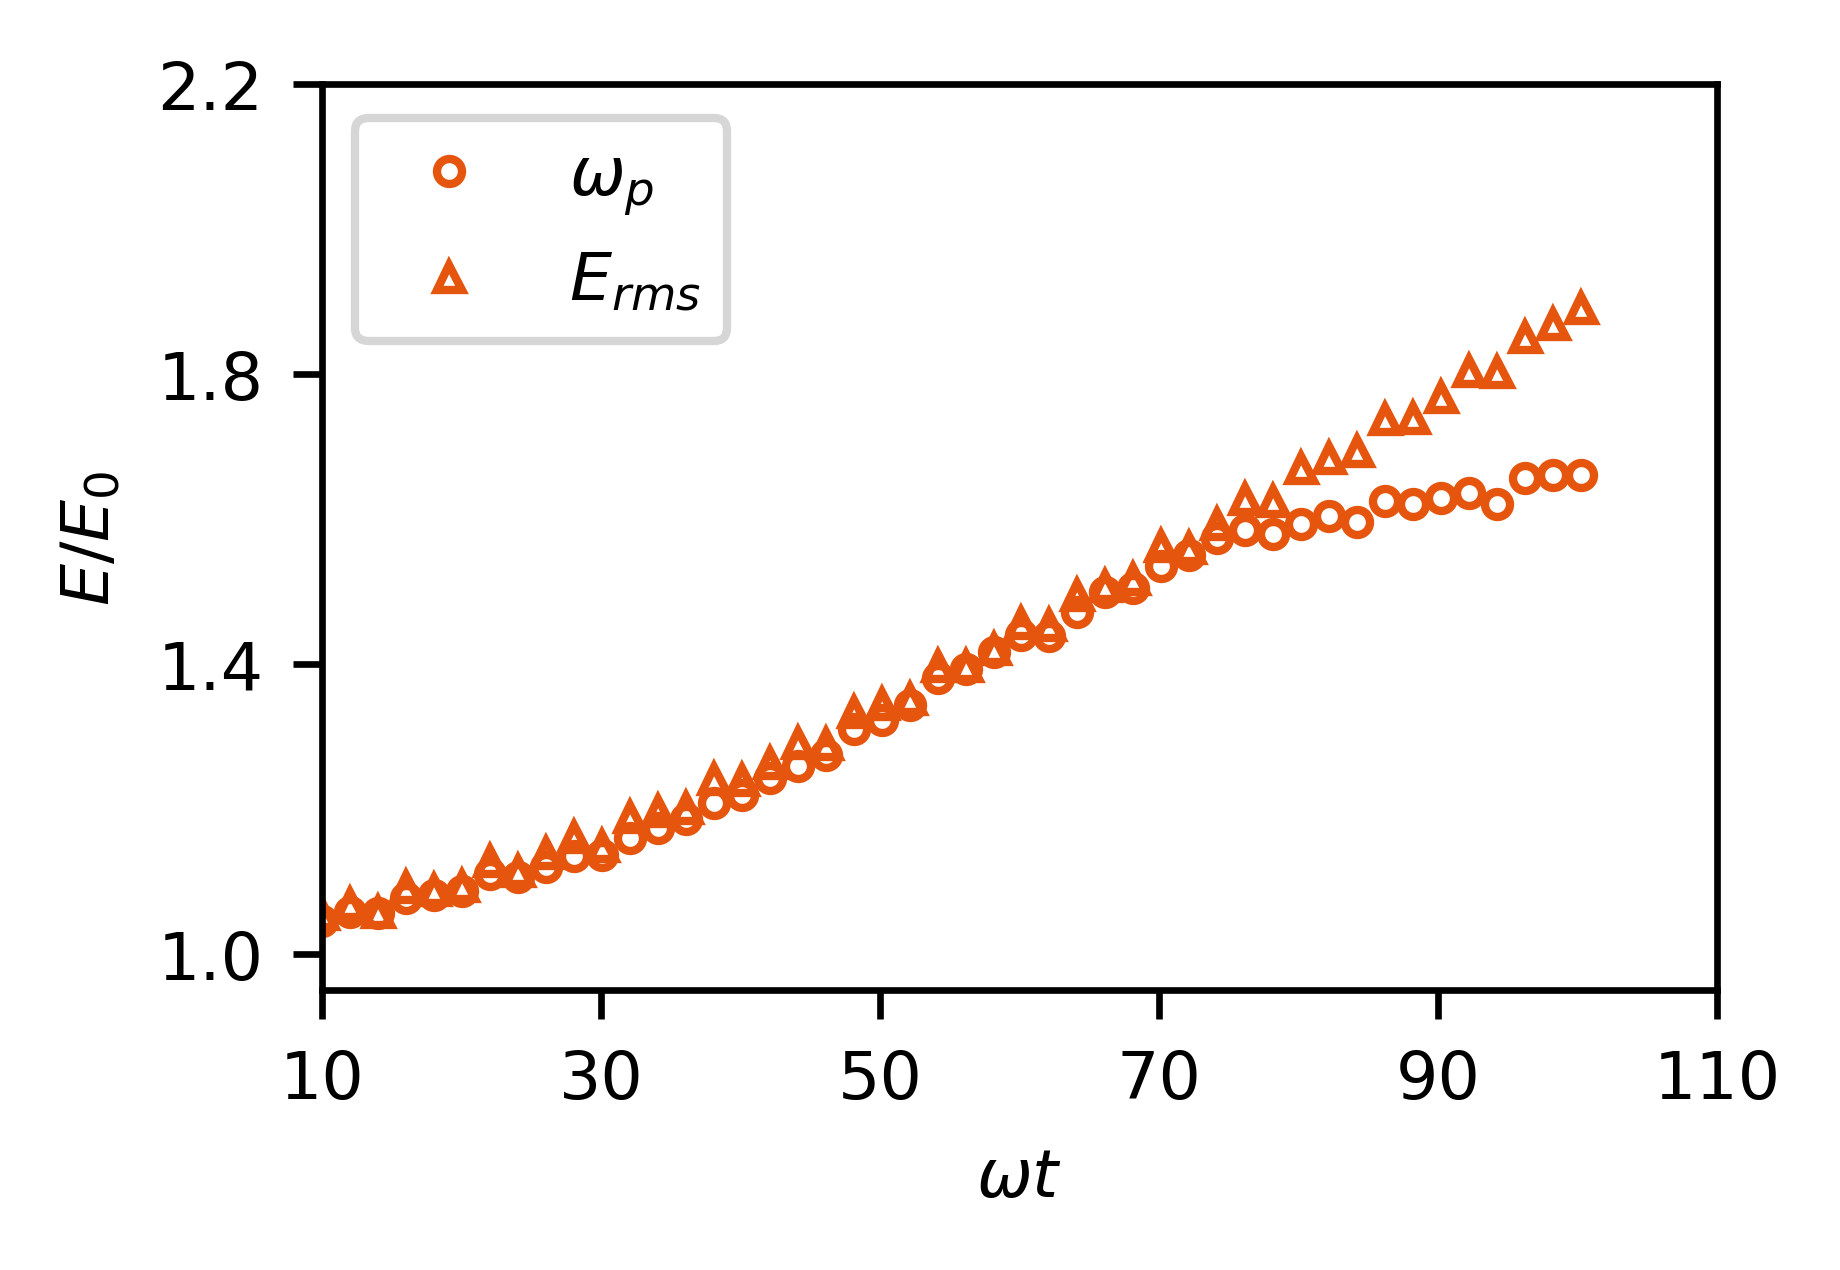

In [86]:
"""Wave growth"""
"""Energy plot"""
fig = plt.figure(figsize=[3,2]); ax = plt.gca()

t_spectrum = np.array(t_spectrum) # t_spectrum is from 2d fft


"""Plot the rms eta or the Fp"""
case = case1
imax = 60
plt.plot(case.t*case.wave.omega , np.array(case.Ep)/case.Ep[0], marker = 'o', mfc='none',
         label = r'$\omega_p$', lw=0, markersize=3, color=plt.get_cmap('tab20c')(4)) 
plt.plot(case.t*case.wave.omega , case.Erms/case.Erms[0], color=plt.get_cmap('tab20c')(4), marker = '^', mfc='none',
         markeredgewidth=1, lw=0, markersize=3, label = r'$E_{rms}$')

# case = case2
# imax = 30
# T = 2*np.pi/case.wave.omega 
# # plt.plot(np.array(case.t[0:imax])/T, np.array(case.energy[0:imax])/case.energy[0], marker = '.',
# #          label = r'$u_*/c=%.2f$' %(case.ustar/case.wave.c), lw=1, markersize=3,
# #          color=plt.get_cmap('tab20c')(5)) 
# plt.plot(t_spectrum/T, case.Fp/case.Fp[0], color=plt.get_cmap('tab20c')(5), marker = '>', mfc='none',
#          markeredgewidth=1, lw=0, markersize=3, label = r'$u_*/c=%.2f$' %(case.ustar/case.wave.c))

"""Fit an exponential"""
# T = 2*np.pi/case1.wave.omega
# case1.wa, wb = np.polyfit(t_spectrum/T, np.log(case1.Fp/case1.Fp[0]), 1)
# plt.plot(t_spectrum/T, np.exp(case1.wa*t_spectrum/T+wb), color=plt.get_cmap('tab20c')(4), alpha = 0.5)
# print(case1.wa)
# T = 2*np.pi/case2.wave.omega
# case2.wa, wb = np.polyfit(t_spectrum/T, np.log(case2.Fp/case2.Fp[0]), 1)
# plt.plot(t_spectrum/T, np.exp(case2.wa*t_spectrum/T+wb), color=plt.get_cmap('tab20c')(5), alpha = 0.6)
# print(case2.wa)

# ax.text(0.4, 0.9, r'$\bar{\beta} = %.3f$' % case1.wa, ha='center', va='center', rotation=0., fontsize=6, 
#         color=plt.get_cmap('tab20c')(4), transform=ax.transAxes)
# ax.text(0.87, 0.48, r'$\bar{\beta} = %.3f$' % case2.wa, ha='center', va='center', rotation=0., fontsize=6, 
#         color=plt.get_cmap('tab20c')(5), transform=ax.transAxes)
plt.xlabel(r'$\omega t$'); plt.ylabel(r'$E/E_0$')
plt.ylim([0.95,2]); plt.xlim([10,110])
plt.yticks(np.arange(1, 2.2, 0.4))
plt.xticks(np.arange(10, 130, 20))
plt.legend(loc='upper left')
# fig.savefig('/home/jiarong/Downloads/ICTAM/wavegrowth_Fp.pdf')

In [32]:
interface = Interface2D(L0 = 2*np.pi, N = 512, 
                        path = case1.path, 
                        pre='eta/eta_loc_t', t = 76, PRUNING=True)
tau0 = case1.ustar**2*case1.rho2
L0 = case1.L0
interface.stress(tau0, case1.mu2)

In [13]:
""" FIGURE_PREP: the camera angle of surface stress. 
    I think the new version of matplotlib broke this. """
# How to draw coordinate arrow
# https://stackoverflow.com/questions/57015852/is-there-a-way-to-plot-a-3d-cartesian-coordinate-system-with-matplotlib/57790156
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)


def cuboid_data(center, size):
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = np.array([[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]])  # x coordinate of points in inside surface
    y = np.array([[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]])    # y coordinate of points in inside surface
    z = np.array([[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]])                # z coordinate of points in inside surface
    return x, y, z

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


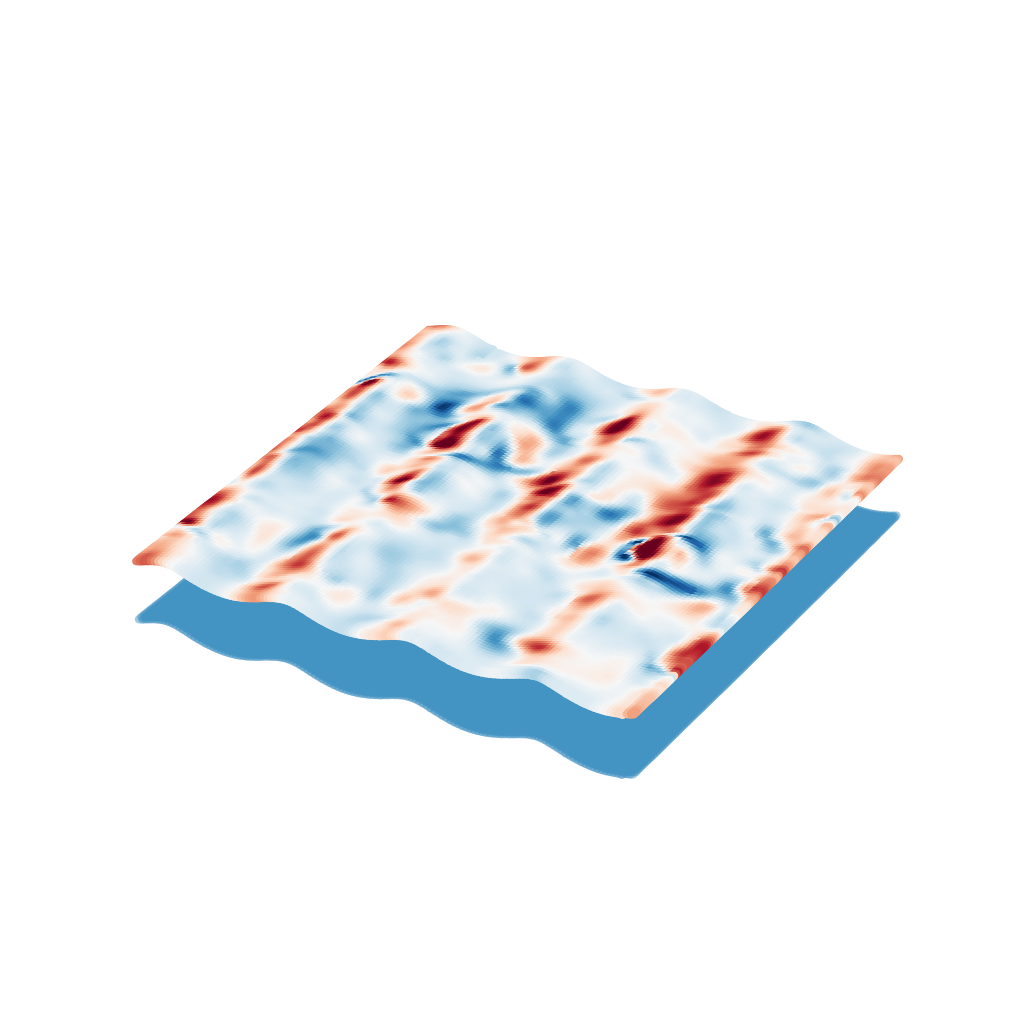

In [22]:
""" FIGURE: 3D imshow with plot_surface (the tilted iso view). """
fig = plt.figure(figsize=[4,2]); ax = plt.axes(projection='3d')
xx, yy = np.meshgrid(interface.xarray, interface.xarray)

X =  xx 
Y =  yy
Z =  interface.eta

data = (interface.p)/tau0
# Range of colormap is (0,1) so need to renormalize data

ax.plot_surface(X, Y, Z+0.5, rstride=4, cstride=4, facecolors=plt.cm.RdBu((1-data/15)/2), shade=False)
ax.set_axis_off()
ax.set_zlim([0,np.pi]); ax.set_xlim([-np.pi,np.pi]); ax.set_ylim([-np.pi,np.pi])

"""Draw a simple line"""
xp = interface.xarray; yp = np.ones(512)*(-np.pi-0.05); zp = np.average(interface.eta, axis=0)
# ax.plot(xp, yp, zp+0.5, c='k')
# ax.plot(xp, yp+(2*np.pi+0.1), zp+0.5, c='k')

ax.plot_surface(X, Y, Z, rstride=4, cstride=4, facecolors=plt.cm.RdBu(0.8+data*0), shade=False, alpha=0.5)

# """Here we create the arrows:"""
# arrow_prop_dict = dict(mutation_scale=10, arrowstyle='->', shrinkA=0, shrinkB=0)
# a = Arrow3D([-3,-2], [-5, -5], [1, 1], **arrow_prop_dict, color='k')
# ax.add_artist(a)
# a = Arrow3D([-3, -3], [-5, -4], [1, 1], **arrow_prop_dict, color='k')
# ax.add_artist(a)
# a = Arrow3D([-3, -3], [-5, -5], [1, 2], **arrow_prop_dict, color='k')
# ax.add_artist(a)
# a = Arrow3D([3, 3], [-3, -3], [1, 1.5], **arrow_prop_dict, color='k')
# ax.add_artist(a)
# ax.text(0.0, 0.0, -0.1, r'$0$')
# ax.text(-1.9, -4, 0.8, r'$x$', fontname="CMU serif")
# ax.text(-3, -3.9, 1, r'$y$')
# ax.text(-3, -4, 2.1, r'$z$')
fig.savefig('./figures_jfm/pressure_camera.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


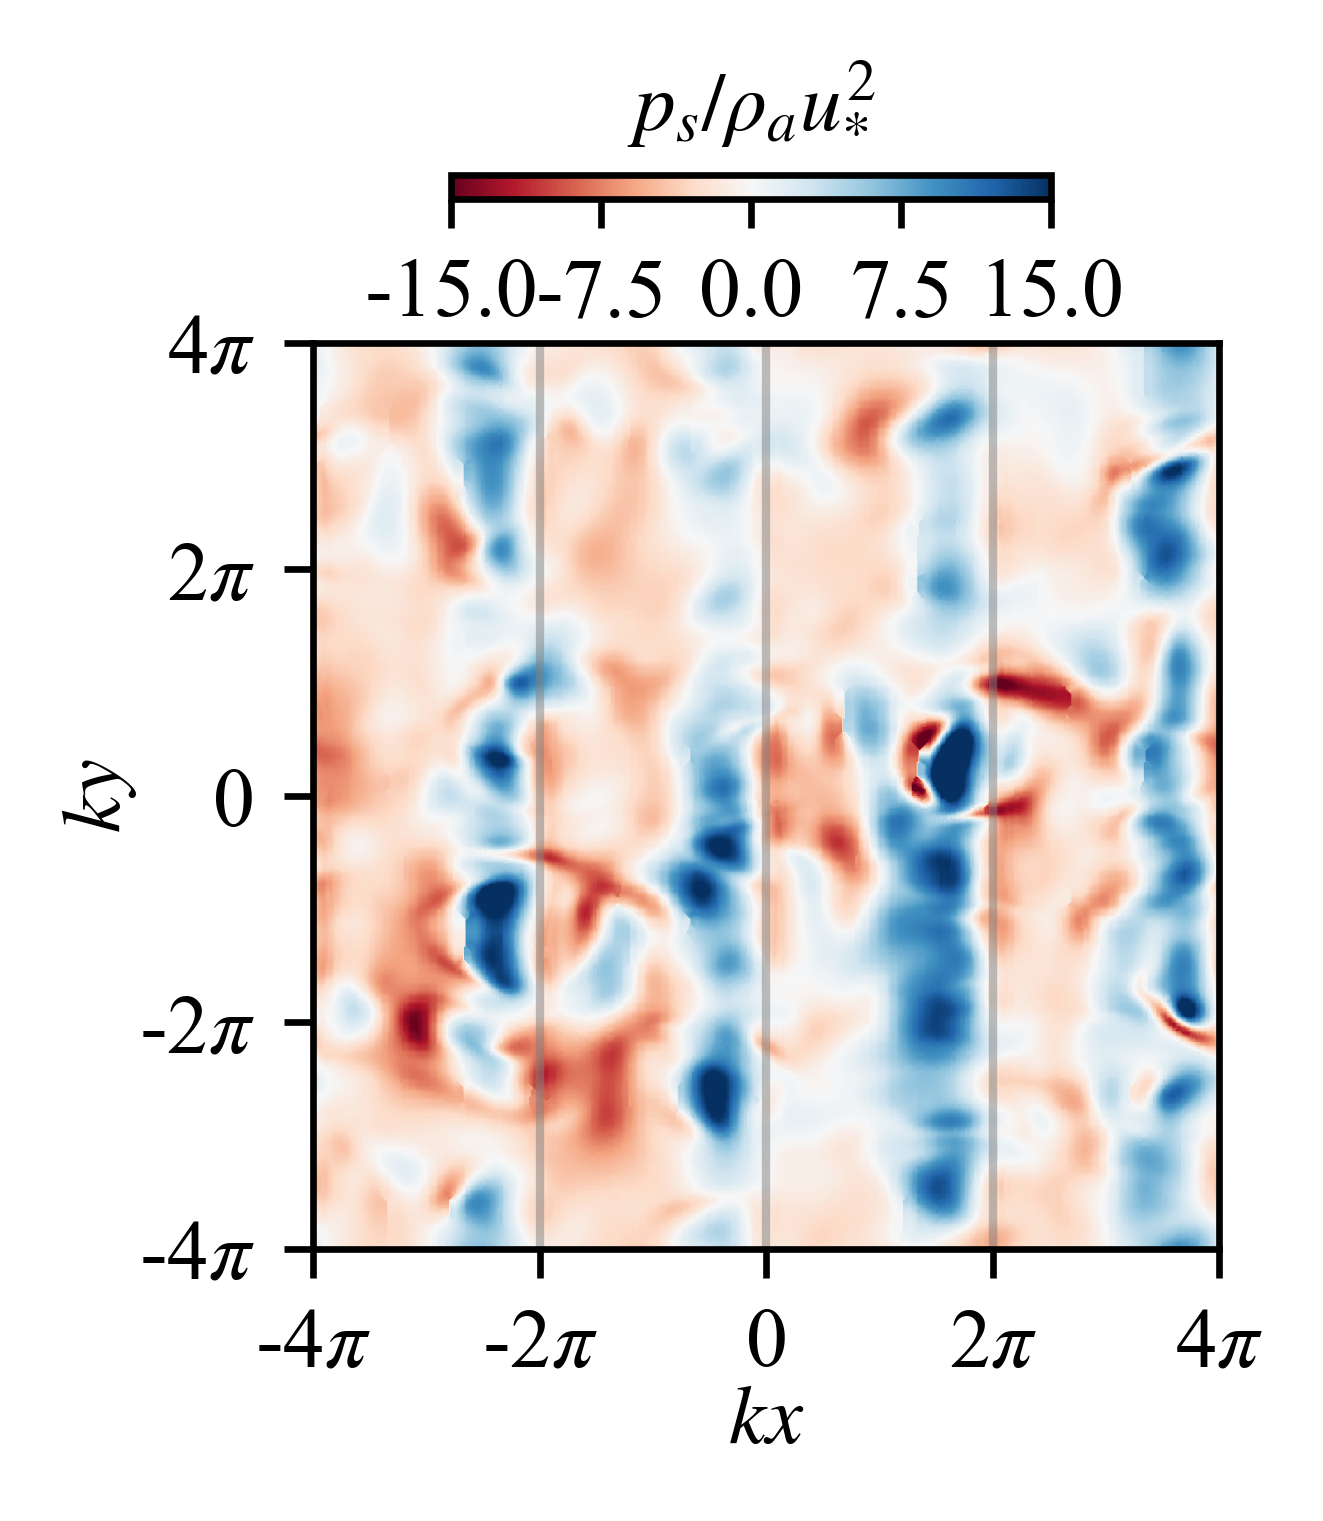

In [89]:
""" FIGURE: Visualization of pressure """
fig = plt.figure(figsize=[2,2]); ax = plt.gca()
k = 4
pshifted = np.roll(interface.p, -interface.idx, axis=1)
pcontour = plt.imshow(pshifted/tau0, cmap='RdBu', vmax = 15, vmin = -15, extent = [-L0/2*k,L0/2*k,-L0/2*k,L0/2*k])
# plt.plot(interface.xarray, np.average(interface.eta,axis=0)+2*np.pi-1, c='gray')
# plt.plot(interface.xarray, np.average(interface.eta,axis=0)-1, c='gray')
for crest in (-2*np.pi, 0 , 2*np.pi):
    plt.plot(np.ones(512)*crest, interface.xarray*k, c='gray', lw=1, alpha=0.5)
cb_ax = fig.add_axes([0.25,1.0,0.5,0.02])
v1 = np.linspace(-15, 15, 5, endpoint=True)
cbar = fig.colorbar(pcontour, orientation="horizontal", cax=cb_ax, ticks=v1)
cbar.ax.text(0.5, 4, r'$p_s/\rho_{a}u_{*}^2$', ha='center', va='center', transform=cbar.ax.transAxes, fontsize=10)

ax.set_xlabel(r'$kx$', labelpad=0)
ax.set_ylabel(r'$ky$', labelpad=0)
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.yaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=2*np.pi))
ax.yaxis.set_major_locator(MultipleLocator(base=2*np.pi))
ax.set_xlim([-4*np.pi,4*np.pi]); ax.set_ylim([-4*np.pi,4*np.pi])
fig.savefig('figures_jfm/pressure_projection.pdf', bbox_inches='tight', pad_inches=0.1)
fig.savefig('figures_jfm/pressure_projection.eps', bbox_inches='tight', pad_inches=0.1)
# fig.savefig('./figures/pressure.pdf', bbox_inches='tight', pad_inches=0.1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


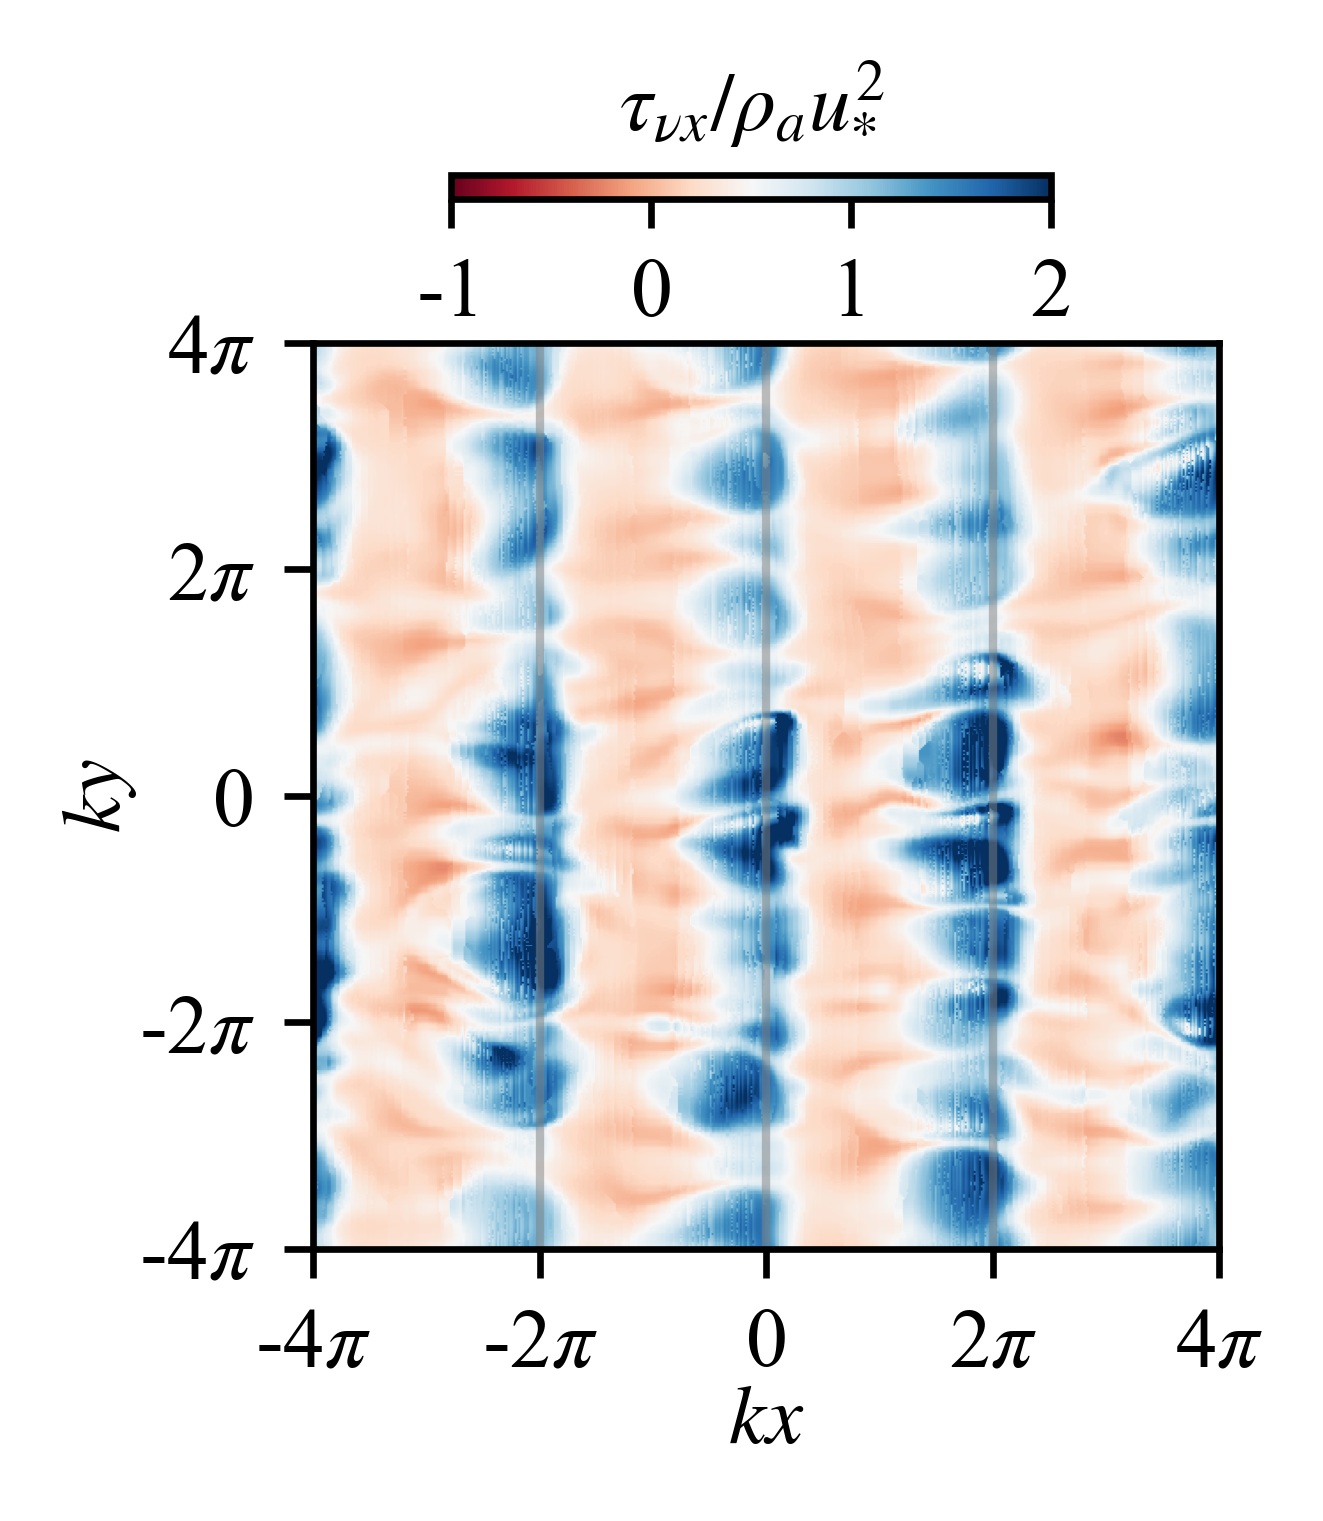

In [90]:
"""Visualization of shear stress"""
fig = plt.figure(figsize=[2,2]); ax = plt.gca()
k = 4
taushifted = np.roll(interface.tau_nux, -interface.idx, axis=1)
pcontour = plt.imshow(taushifted/tau0, cmap='RdBu', vmax = 2, vmin = -1, extent = [-L0/2*k,L0/2*k,-L0/2*k,L0/2*k])
# plt.plot(interface.xarray, np.average(interface.eta,axis=0)+2*np.pi-1, c='gray')
# plt.plot(interface.xarray, np.average(interface.eta,axis=0)-1, c='gray')
for crest in (-2*np.pi, 0 , 2*np.pi):
    plt.plot(np.ones(512)*crest, interface.xarray*k, c='gray', lw=1, alpha=0.5)

v1 = np.arange(-1,3,1)
cb_ax = fig.add_axes([0.25,1.0,0.5,0.02])
cbar = fig.colorbar(pcontour, orientation="horizontal", cax=cb_ax, ticks=v1)
cbar.ax.text(0.5, 4, r'$\tau_{\nu x}/\rho_{a}u_{*}^2$', ha='center', va='center', transform=cbar.ax.transAxes, fontsize=10)
# cb_ax = fig.add_axes([1, 0.25, 0.02, 0.5])
# cbar = fig.colorbar(pcontour, orientation="vertical", cax=cb_ax, ticks=v1)
# cbar.ax.text(0.5, 1.1, r'$\tau_{\nu x}/\rho_{a}u_{*}^2$', ha='center', va='center', transform=cbar.ax.transAxes, fontsize=10)

ax.set_xlabel(r'$kx$', labelpad=0)
ax.set_ylabel(r'$ky$', labelpad=0)
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.yaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=2*np.pi))
ax.yaxis.set_major_locator(MultipleLocator(base=2*np.pi))
ax.set_xlim([-4*np.pi,4*np.pi]); ax.set_ylim([-4*np.pi,4*np.pi])
fig.savefig('figures_jfm/shear_projection.pdf', bbox_inches='tight', pad_inches=0.1)
fig.savefig('figures_jfm/shear_projection.eps', bbox_inches='tight', pad_inches=0.1)
# fig.savefig('./figures/shear.pdf', bbox_inches='tight', pad_inches=0.1)

In [ ]:
plt.figure(figsize=[4,3])
plt.imshow((interface.eta_tile-np.average(interface.eta_tile))*4, cmap='RdBu', vmax = 0.3, vmin = -0.3, extent = [-L0/2,L0/2,-L0/2,L0/2])
cbar = plt.colorbar(); plt.axis('off')
ax = plt.gca()
ax.text(1.1,1.05, r'$\eta k$', ha='center', va='center', transform=ax.transAxes)

In [ ]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[4][0:-1]-np.average(pinterp[3][0:-1]))/(rho_a*0.25**2), 
         label = r'$p/\rho_{a}u_*^2$', color = 'blue')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv[0][0:-1])*5/(rho_a*0.25**2), label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4*10, label=r'$10\eta(x)k $', color = 'gray')
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', label=r'$10d\eta/dx$ ', color = 'gray')
plt.xlabel(r'$x/\lambda$')
plt.ylim([-14,14])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

In [80]:
'''
Interpolate the surface pressure from the field output.
This is a serialized version of the function.
'''

from scipy.signal import hilbert
from scipy.signal import butter,filtfilt
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

# Filter requirements.
def butter_lowpass_filter(data, CUT=4):
    T = 4     # Sample Period
    fs = 512/T      # Sample rate, Hz
    cutoff = CUT    # desired cutoff frequency of the filter, Hz, slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g4_ak0.2_MU8_LEVEL10_emax0.3/'

NGRID = 512
rho_a = 0.001225
nu_a = 0.25*(2*np.pi-1)/720
NSLICE = 256

t = 84
''' 
Reading in pressure and immediately average over z (quasi 2D assumption).
Should change to fully 3D later. 
'''
pair = {'name':'pair', 'value':[]}
f = {'name':'f', 'value':[]}
field = pair # Later can add more field 
for sn in range(0,NSLICE-1):
    filename = working_dir + 'field/'+field['name']+'_run_t%g_slice%g' % (t,sn)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    snapshot.reshape([NGRID,NGRID+1])
    field['value'].append(snapshot[:,0:NGRID].astype(np.float))
field['value'] = np.average(np.array(field['value']), axis=0)

# To-do: unify the name!
field = f
for sn in range(0,NSLICE-1):
    filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    snapshot.reshape([NGRID,NGRID+1])
    field['value'].append(snapshot[:,0:NGRID].astype(np.float))
field['value'] = np.average(np.array(field['value']), axis=0)

''' Read in eta and immediately average over z'''
L0 = 2*np.pi
PRUNING = True
filename = working_dir + 'eta/eta_t%g' % t
snapshot = pd.read_table(filename, delimiter = ',')
if PRUNING:
    snapshot = snapshot[snapshot.x != 'x']
    snapshot = snapshot.astype('float')
    snapshot = snapshot[snapshot.pos < 1 + 0.4/4]
eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos)}
# Interpolate over x-z plane with the same resolutions
# xarray = np.linspace(-L0/2.,L0/2,NGRID)
# zarray = np.linspace(-L0/2.,L0/2,NGRID)
'''
TODO: Figure out why these two are so different!
'''
xarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
zarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
x_tile, z_tile = np.meshgrid(xarray,zarray)
eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                         (x_tile, z_tile), method='nearest')
eta_1D = np.average(eta_tile, axis=0)

''' Compute 1D eta gradient '''
eta_1D_filtered = butter_lowpass_filter(eta_1D)
eta_1D_grad = np.gradient(eta_1D)/(L0/NGRID)
# eta_1D_grad[0] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
# eta_1D_grad[-1] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
eta_1D_grad_filtered = butter_lowpass_filter(eta_1D_grad)

''' Remove the constant and interpolate p '''
parray = pair['value']
farray = f['value']
pbase = np.average(parray[parray!=0])
print(pbase)
pshift = (parray-pbase)*(1-farray)
ygrid = np.linspace(0.,L0,NGRID,endpoint=False)+L0/NGRID/2
# Removing the too high point 
# that are very close to eta and might mess with the interp
pshift[pshift/0.25**2 > 0.5] = 0
# Add some distance
# Test 6 different vertical padded values
pinterp = np.zeros([6, eta_1D_grad.shape[0]])
for ix in range(0, NGRID-1):
    pgrid = interp1d(ygrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
    for NADD in range(1,7):
        pinterp[NADD-1,ix] = pgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)

''' Compute interpolated shear stress '''    
ux = {'name':'ux', 'value':[]}
uy = {'name':'uy', 'value':[]}
# TODO uy gradient
for field in (ux, uy): # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)
tauv_dudy = np.zeros([6, eta_1D_grad.shape[0]])
tauv_dvdy = np.zeros([6, eta_1D_grad.shape[0]])
tauv_dudx = np.zeros([6, eta_1D_grad.shape[0]])
tauv_dvdx = np.zeros([6, eta_1D_grad.shape[0]])
# Interpolate and then compute the gradient in y 
for ix in range(0, NGRID-1):
    uxgrid = interp1d(ygrid, ux['value'][ix,:], fill_value='extrapolate', kind='quadratic')
    uygrid = interp1d(ygrid, uy['value'][ix,:], fill_value='extrapolate', kind='quadratic')
    for NADD in range(1,7):
        ux_interp1 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
        ux_interp2 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*(NADD+1))
        tauv_dudy[NADD-1,ix] = (ux_interp2-ux_interp1)/(L0/NGRID)
        uy_interp1 = uygrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
        uy_interp2 = uygrid(eta_1D_filtered[ix] + L0/NGRID*(NADD+1))
        tauv_dvdy[NADD-1,ix] = (uy_interp2-uy_interp1)/(L0/NGRID)
# Compute the gradient in x first then interpolater
uxgrad = np.gradient(ux['value'], edge_order = 2, axis = 0)/(L0/NGRID)
uygrad = np.gradient(uy['value'], edge_order = 2, axis = 0)/(L0/NGRID)
for ix in range(0, NGRID-1):
    uxgrad_grid = interp1d(ygrid, uxgrad[ix,:], fill_value='extrapolate', kind='quadratic')
    uygrad_grid = interp1d(ygrid, uygrad[ix,:], fill_value='extrapolate', kind='quadratic')
    for NADD in range(1,7):
        tauv_dudx[NADD-1,ix] = uxgrad_grid(eta_1D_filtered[ix] + L0/NGRID*NADD)
        tauv_dvdx[NADD-1,ix] = uygrad_grid(eta_1D_filtered[ix] + L0/NGRID*NADD)

''' Compute the integrated force '''
# p force 6 values to deal with uncertainty
pforce = np.zeros(6)
for NADD in range(1,7):
    ''' TODO: determine is from 1 to -2 is the way to go '''
    pforce[NADD-1] = np.sum(pinterp[NADD-1,:]*eta_1D_grad_filtered[:])/NGRID
print (pforce/(rho_a*0.25**2))

# Compute tangential stress
# tang = np.sum(tauv[1,:]*1/(1+eta_1D_grad_filtered[:]**2)**0.5)/NGRID
# print(tang/(rho_a*0.25**2))
# pforce = np.sum(pinterp[3,:]*1/(1+(1/eta_1D_grad_filtered[:])**2)**0.5)/NGRID
# pforce = np.sum(pinterp[4,:]*eta_1D_grad_filtered[:])/NGRID
# print(pforce/(rho_a*0.25**2))

0.04738301571065997
[0.49984773 0.44717    0.4436001  0.42717181 0.41542405 0.40219744]


In [81]:
tang = np.sum(tauv_dudy[0,:])/NGRID*nu_a
print(tang/(0.25**2))

0.5612908908237532


In [ ]:
''' Additional visualization '''
ETA = False
P2D = False
P1D = True

# For 1D eta
if ETA == True:
    plt.figure(figsize=[4,1.5])
    plt.plot(xarray, eta_1D-1, label=r'$\eta(x)$')
    plt.plot(xarray, eta_1D_filtered-1, label=r'$\eta(x)$ smoothed')
    plt.plot(xarray, eta_1D_grad, label=r'$d\eta/dx$')
    plt.plot(xarray, eta_1D_grad_filtered, label=r'$d\eta/dx$ smoothed')
    plt.ylabel(r'$\eta$')
    plt.legend()

# For 2D p after adjusting constant
if P2D == True:
    fig = plt.figure(figsize=[3,4])
    img = plt.imshow((np.rot90((pshift)*(1-farray))/(rho_a*0.25**2)), cmap='RdBu', vmax = 10, vmin = -10, extent = [-L0/2,L0/2,0,L0])
    plt.axis('off')
    cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
#     cbar.ax.text(0, 30, r'$p/\rho_{a}u_*^2$', ha='center', va='center')
    # Demo the eta choice
    plt.plot(xarray, eta_1D_filtered, lw=0.5, c='k')
    NADD = 2
    plt.plot(xarray, eta_1D_filtered+L0/NGRID*NADD, '--', lw=0.5, c='k')

# For 1D interpolated p
if P1D == True:
    plt.figure(figsize=[4,2])
    for (i,p) in enumerate(pinterp):
        plt.plot(xarray, p/(rho_a*0.25**2), label='%g grid pts above' %(i+1))
    # plt.plot(xgrid, pinterp2/0.25**2, label='%g grid pts above' %NADD2)
    plt.ylim([-40,40])
    plt.xlabel('x'); plt.ylabel(r'$p/\rho_{a}u_*^2$')
    plt.legend()

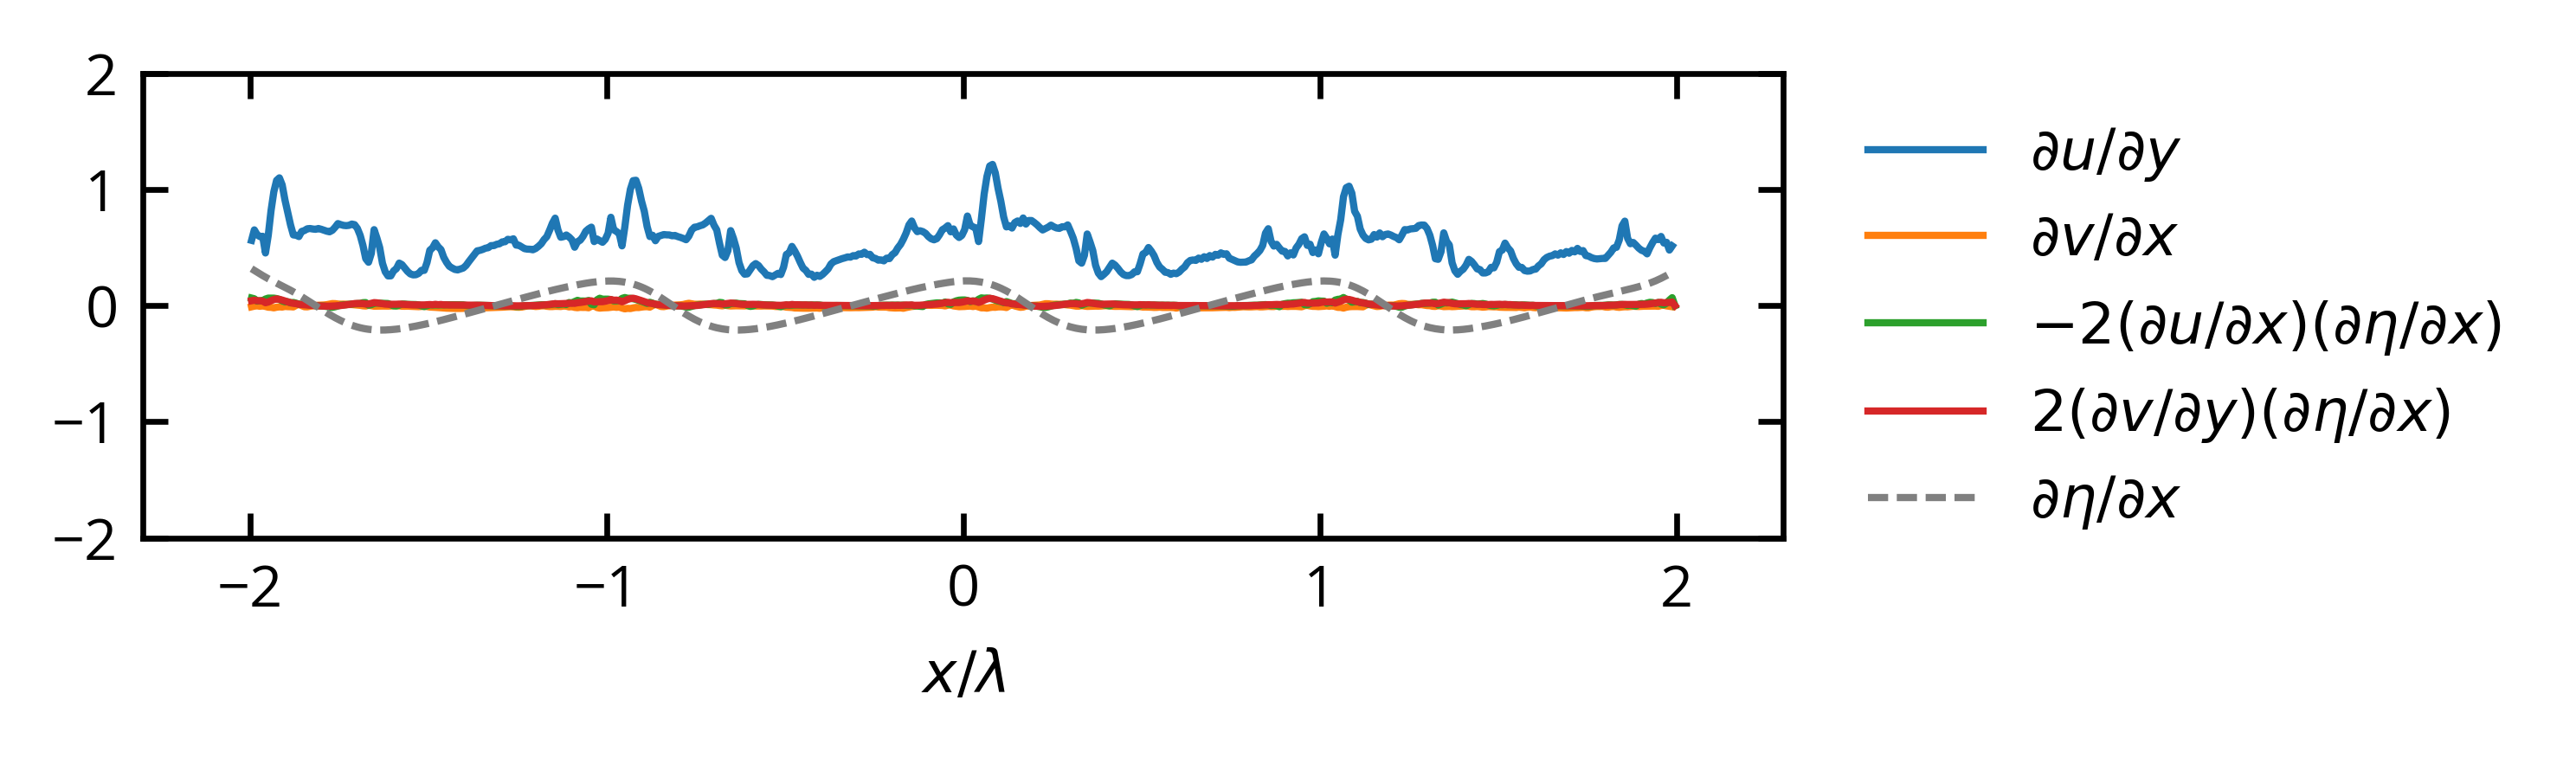

In [46]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dudy[1][0:-1])*nu_a/(0.25**2), 
         label = r'$ \partial u / \partial y $', lw = 1)
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dvdx[1][0:-1])*nu_a/(0.25**2), 
         label = r'$ \partial v / \partial x $', lw = 1)
plt.plot(xarray/(2*np.pi/4), (-2*tauv_dudx[1])*nu_a/(0.25**2)*eta_1D_grad_filtered, 
         label = r'$ -2 (\partial u / \partial x) (\partial \eta/\partial x)$', lw = 1)
plt.plot(xarray/(2*np.pi/4), (2*tauv_dvdy[1])*nu_a/(0.25**2)*eta_1D_grad_filtered, 
         label = r'$ 2 (\partial v / \partial y) (\partial \eta/\partial x)$', lw = 1)
# plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4, label=r'$\eta(x)k $', color = 'gray', lw = 1)
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered, '--', label=r'$\partial \eta/\partial x$ ', color = 'gray', lw = 1)
plt.xlabel(r'$x/\lambda$')
plt.ylim([-2,2])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

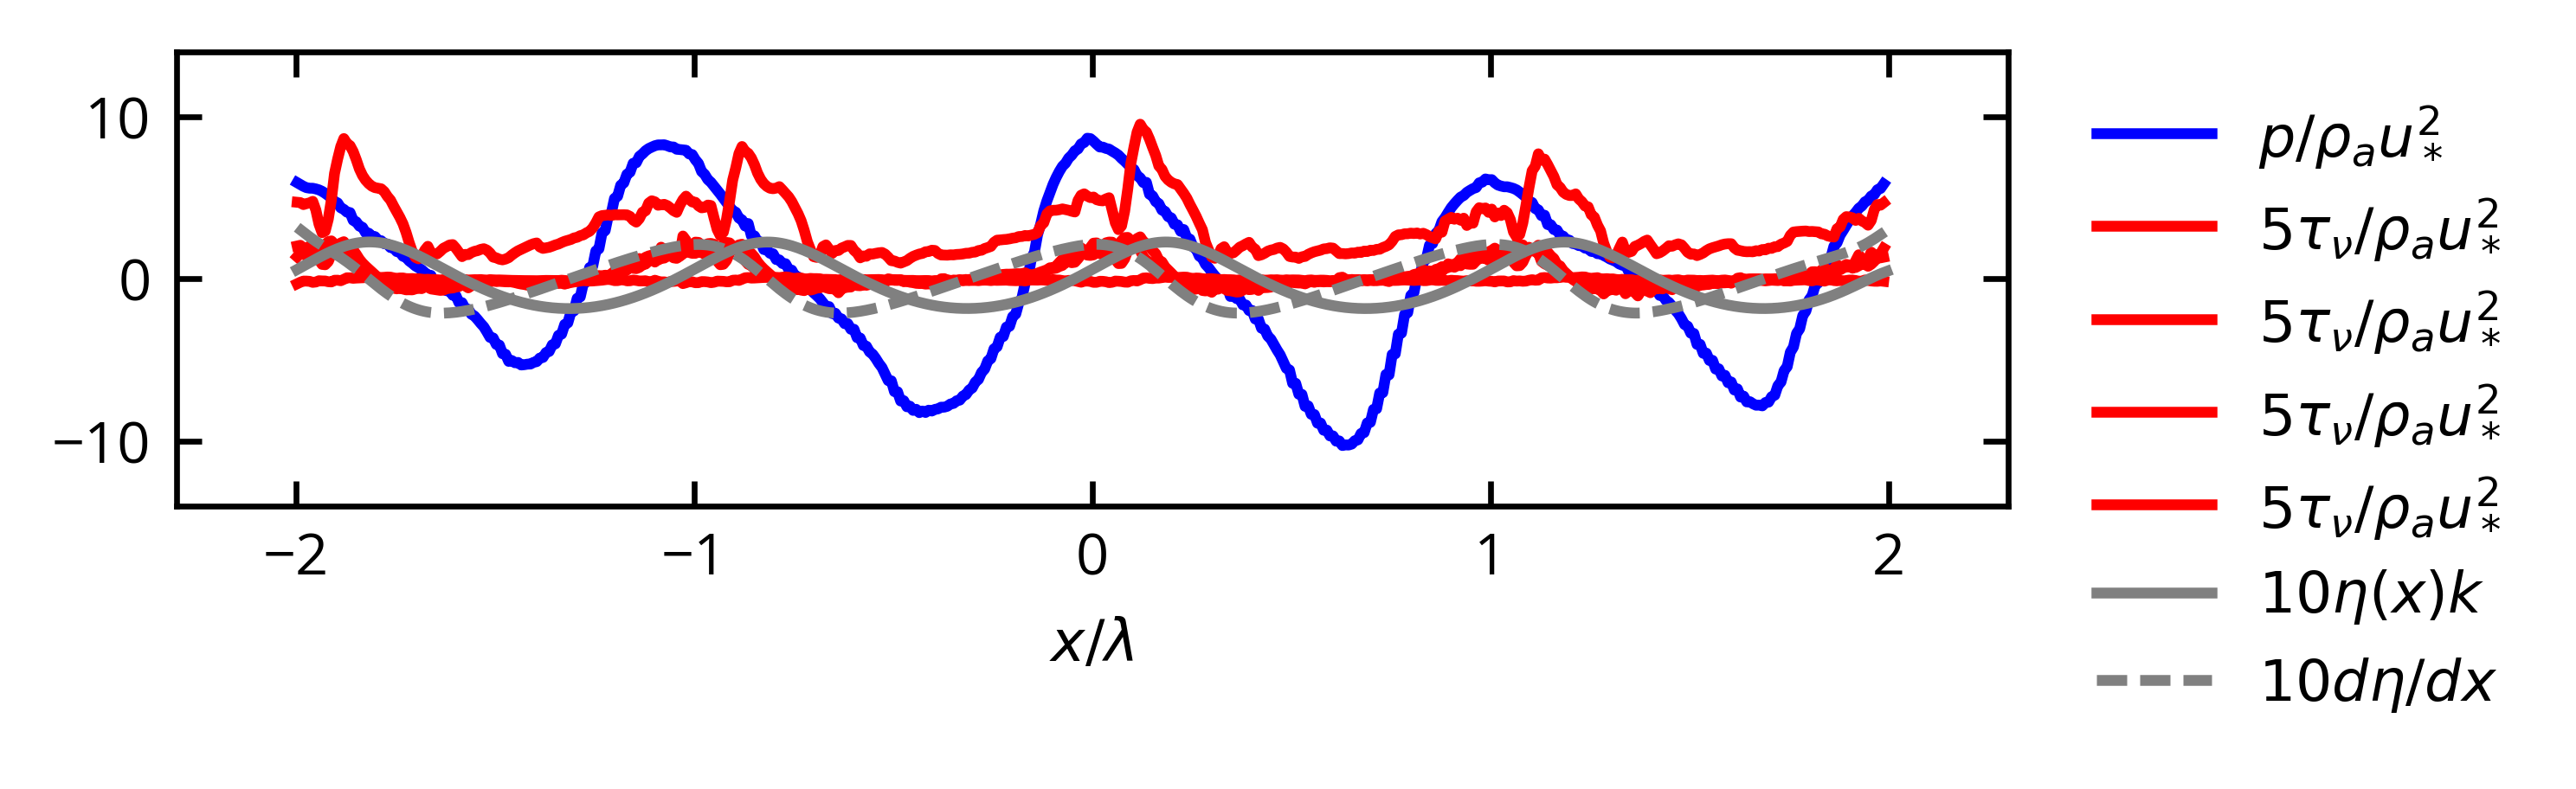

In [29]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[4][0:-1]-np.average(pinterp[4][0:-1]))/(rho_a*0.25**2), 
         label = r'$p/\rho_{a}u_*^2$', color = 'blue')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dudy[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dvdx[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray[0:-1]/(2*np.pi/4), (-2*tauv_dudx[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray[0:-1]/(2*np.pi/4), (2*tauv_dvdy[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4*10, label=r'$10\eta(x)k $', color = 'gray')
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', label=r'$10d\eta/dx$ ', color = 'gray')
plt.xlabel(r'$x/\lambda$')
plt.ylim([-14,14])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

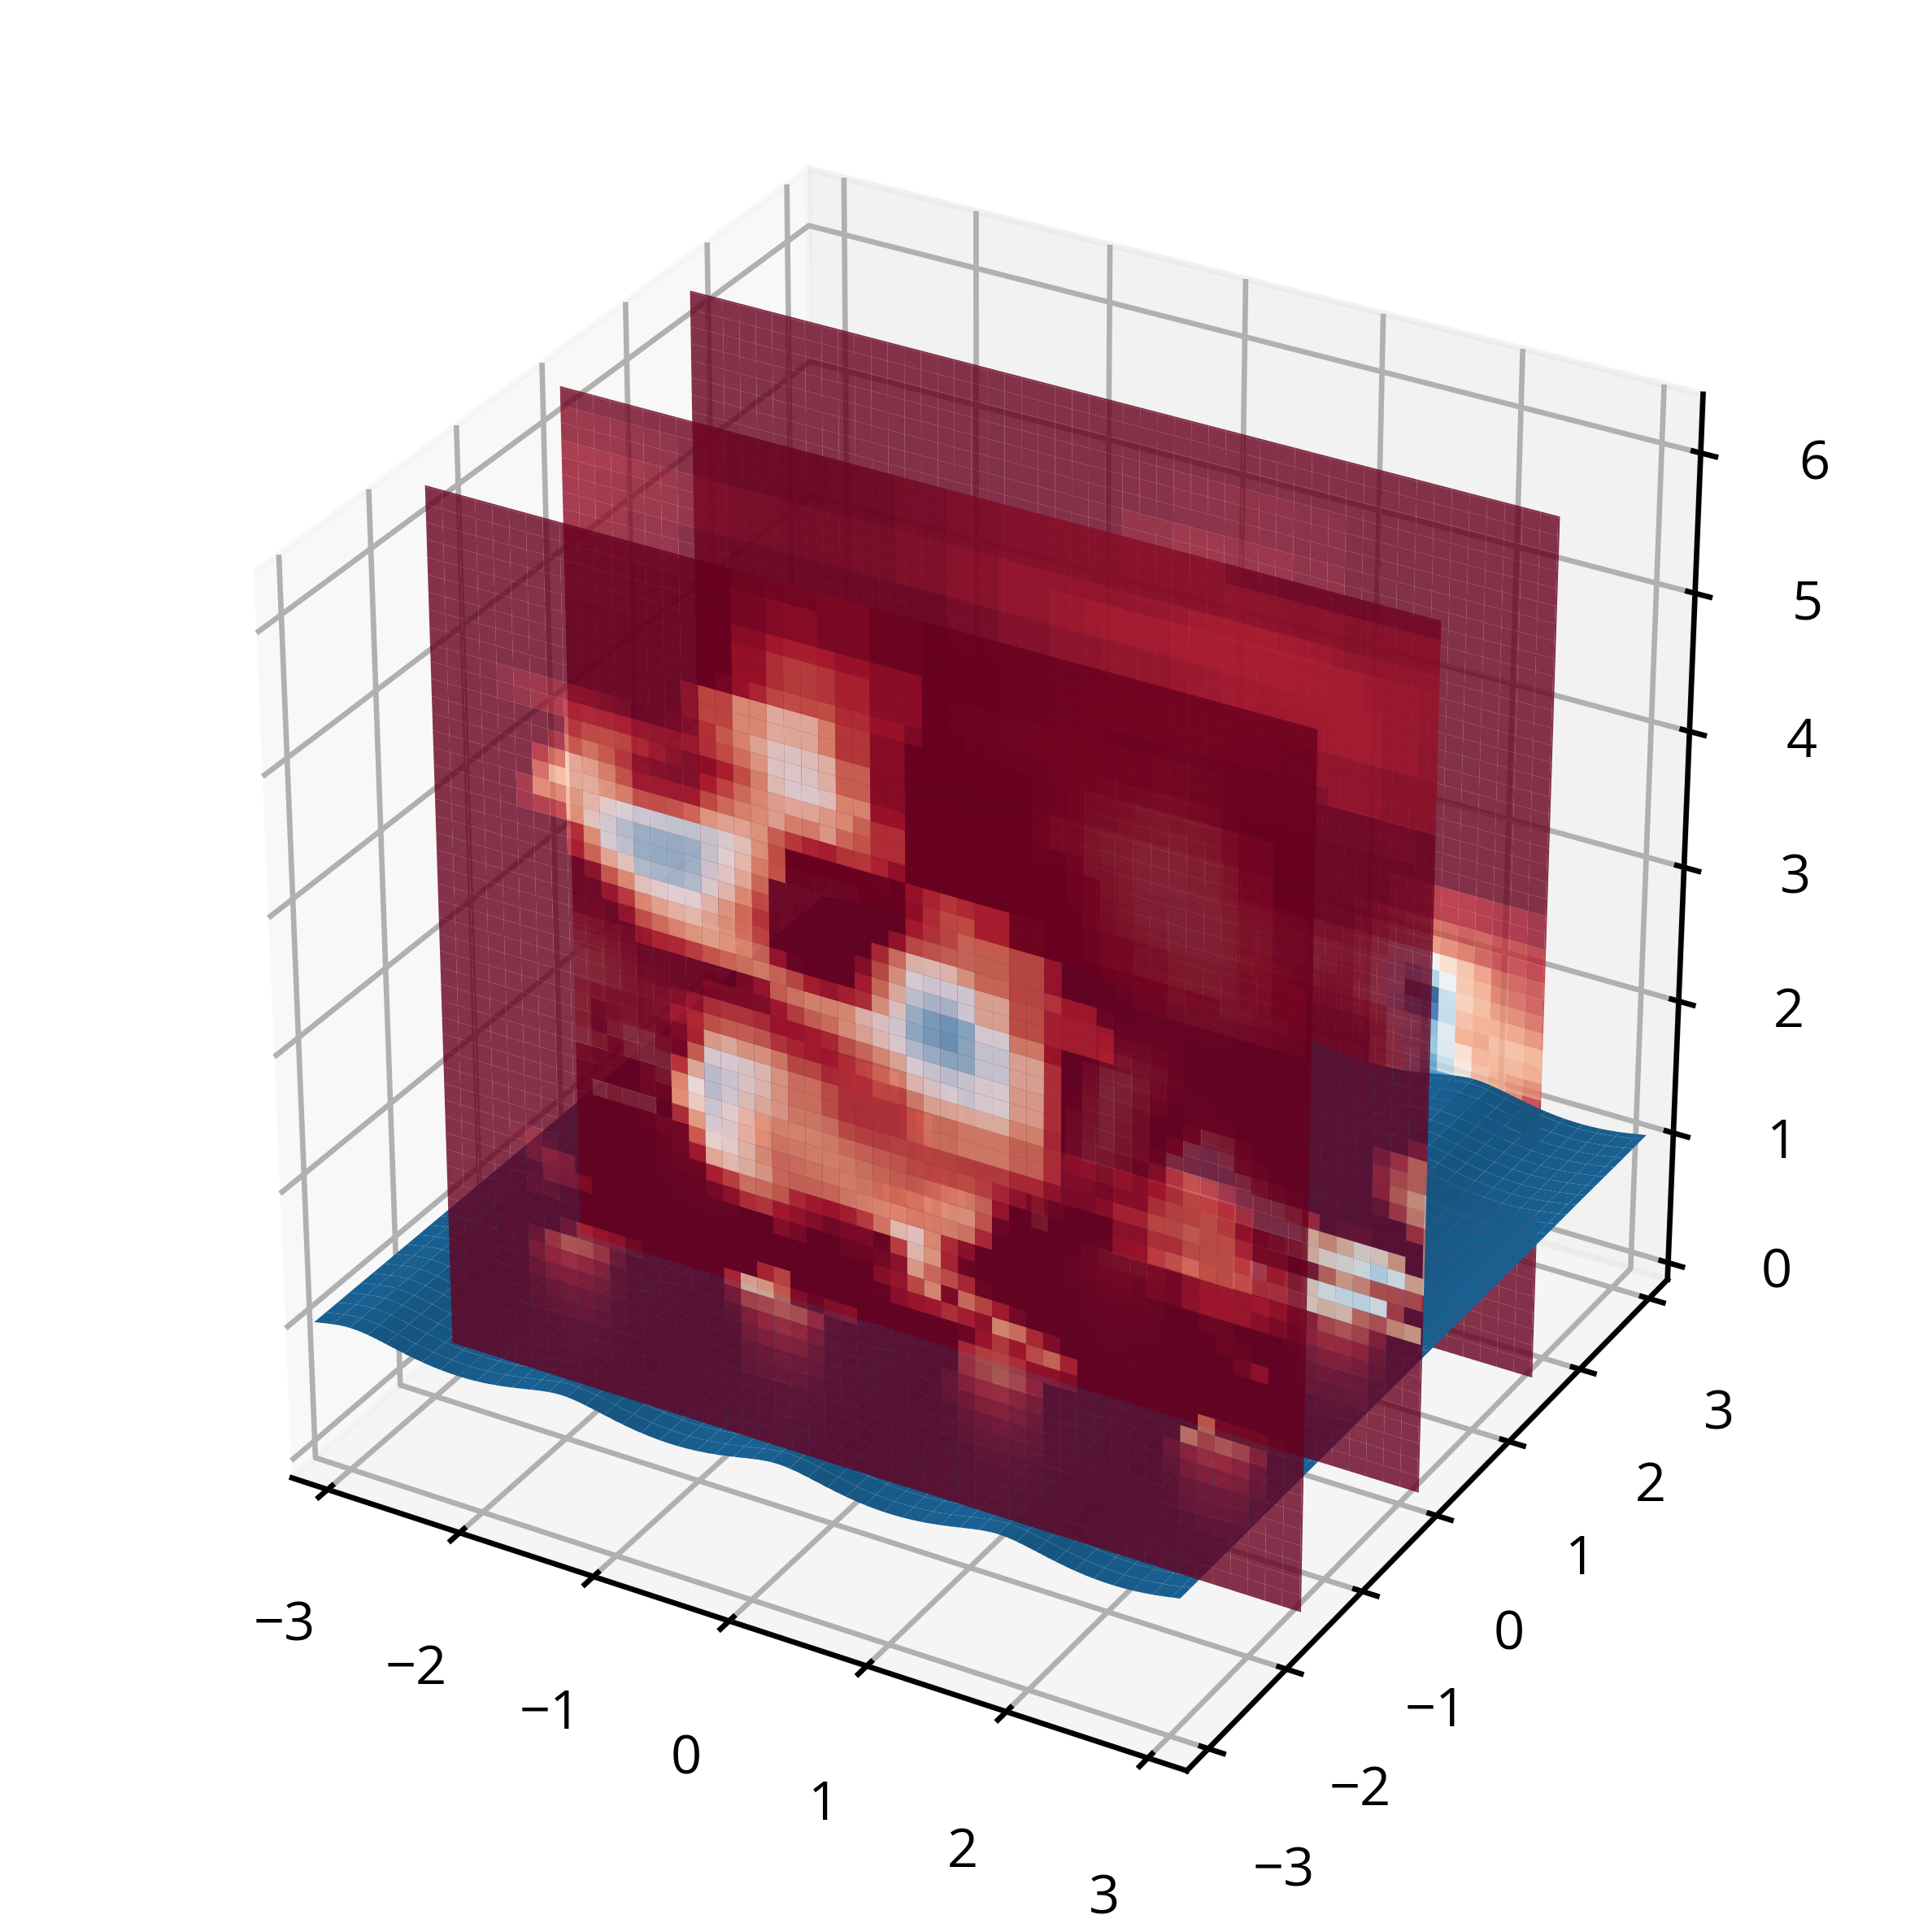

In [48]:
'''
Demonstrating the data processing process. Reference: 
https://stackoverflow.com/questions/25287861/creating-intersecting-images-in-matplotlib-with-imshow-or-other-function/25295272#25295272
https://stackoverflow.com/questions/30464117/plotting-a-imshow-image-in-3d-in-matplotlib
https://matplotlib.org/2.2.2/mpl_toolkits/mplot3d/faq.html
'''
from mpl_toolkits.mplot3d import Axes3D

# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')

# create a 512*512 vertex mesh
xx, zz = np.meshgrid(np.linspace(-np.pi,np.pi,512), np.linspace(0.,2*np.pi,512))
# create vertices for a rotated mesh (3D rotation matrix)
X = xx 
Z = zz
# Take a few slices
t = 68
for sn in range(64,256,64):
    Y = (-np.pi + 2.*np.pi/256*sn)*np.ones([512,512])
    filename = working_dir + 'field/'+'uy'+'_t%g_slice%g' % (t,sn)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    data = snapshot.reshape([NGRID,NGRID+1])
    data = np.rot90(data[:,0:-1].astype(np.float), 3)
    # show the 3D rotated projection
    ax.plot_surface(X, Y, Z, rstride=10, cstride=10, facecolors=plt.cm.RdBu(data), 
                    alpha = 0.8, linewidth=0, shade=False)

xx, yy = np.meshgrid(np.linspace(-np.pi,np.pi,512), np.linspace(-np.pi,np.pi,512))
ax.plot_surface(xx, yy, interface.eta_tile)
ax.set_xlim([-np.pi, np.pi]); ax.set_ylim([-np.pi, np.pi]); ax.set_zlim([0., 2.*np.pi])
plt.show()

In [ ]:
from scipy.signal import hilbert

from scipy.signal import butter,filtfilt
# Filter requirements.
def butter_lowpass_filter(data, CUT=4):
    T = 4     # Sample Period
    fs = 512/T      # Sample rate, Hz
    cutoff = CUT    # desired cutoff frequency of the filter, Hz, slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

class Snapshot:
    '''
    Class for every snapchat
    self.availt: The longest running time
    self.path: Path of the case file
    
    '''  
    def __init__(self, t, working_dir, NSLICE=256, NGRID=256, L0=np.pi*2, trans=False):
        '''
        trans: if phase shift is needed
        self.eta_raw: raw x,z,eta data
        self.eta_tile,self.x_tile,self.z_tile: interpolated eta,x,z with resolution specified by NGRID
        self.eta_1D: eta averaged over z direction
        '''
        self.t = t
        # Declare the fields (do not store as class attribution because of memory issues)
        ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
        uy_3D = {'name':'uy', 'value':[]}
        # Read in the fields
        for field in (ux_3D,uy_3D):
            for sn in range (0,NSLICE-1):
                filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (self.t,sn)
                snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                snapshot.reshape([NGRID,NGRID+1])
                field['value'].append(snapshot[:,0:NGRID].astype(np.float))
            field['value'] = np.array(field['value'])
        # Read in eta
        filename = working_dir + 'eta/eta_t%g' % self.t
        snapshot = pd.read_table(filename, delimiter = ',')
        self.eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos),
                       'p1':np.array(snapshot.p_p1), 'p2':np.array(snapshot.p_p2)}
        # Interpolate over x-z plane with the same resolutions
        xarray = np.linspace(-L0/2,L0/2,NGRID); zarray = np.linspace(-L0/2,L0/2,NGRID)
        self.x_tile, self.z_tile = np.meshgrid(xarray,zarray)
        self.eta_tile = griddata((self.eta_raw['x'].ravel(), self.eta_raw['z'].ravel()), self.eta_raw['eta'].ravel(), 
                                 (self.x_tile, self.z_tile), method='nearest')
        # !To-dos: test for non quasi 1D cases
        self.eta_1D = np.average(self.eta_tile, axis=0)
        # Compute the Reynolds stress
#         self.ux_1D = np.average(ux_3D['value'], axis=(0,1))
#         self.uy_1D = np.average(uy_3D['value'], axis=(0,1))
#         ux_1D_broadcast = np.tile(self.ux_1D, (NSLICE-1, NGRID, 1))
#         uy_1D_broadcast = np.tile(self.uy_1D, (NSLICE-1, NGRID, 1))
#         re_stress_3D = (ux_3D['value']-ux_1D_broadcast)*(uy_3D['value']-uy_1D_broadcast)
#         # Include only z direction averaged 2D profile
#         self.ux_2D = np.average(ux_3D['value'], axis=0)
#         self.uy_2D = np.average(uy_3D['value'], axis=0)
#         self.re_stress_2D = np.average(re_stress_3D,axis=0)             
        # Hilbert transform, performed along x        
        # Filter the data (subtract the mean)
        if trans == True:
            self.eta_1D_filtered = butter_lowpass_filter(self.eta_1D-np.average(self.eta_1D))
            analytic_signal = hilbert(self.eta_1D_filtered)
            self.phase = np.angle(analytic_signal)
            # Shift the velocity field along x axis so that phase starts at 0
            self.idx = (np.abs(self.phase - 0)).argmin()
            self.eta_1D_shift = np.roll(self.eta_1D, -self.idx)
#             self.ux_3D_shift = {'name':'ux_shift', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
#             self.uy_3D_shift = {'name':'uy_shift', 'value':[]}
#             for (field,field_shift) in zip((self.ux_3D,self.uy_3D),(self.ux_3D_shift,self.uy_3D_shift)):
#                 field_shift['value'] = np.roll(field['value'], -self.idx, axis=1)

In [ ]:
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
# snapshot_ensemble_360_moving_MU32 = []
for i in tqdm(range(0,1)):
    t = 76 + i
    snapshot = Snapshot(t, working_dir=dirname, NSLICE=256, NGRID=512, L0=2*np.pi)

In [ ]:
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
# snapshot_ensemble_360_moving_MU32 = []
for i in tqdm(range(0,1)):
    t = 57 + i
    snapshot = Snapshot(t, working_dir=dirname, NSLICE=256, NGRID=512, L0=2*np.pi)

In [ ]:
from scipy.interpolate import interp1d
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
# working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_precursor_REtau720_ak0.2_LEVEL10_emax0.3/'
# t = 59

def pressure(t, PRUNING = True):
    '''
    This is a function that compute the integrated form drag at time t
    '''
    
    NGRID = 512
    rho_a = 0.001225
    nu_a = 0.25*(2*np.pi-1)/720
    ''' 
    Reading in pressure and immediately average over z (quasi 2D assumption).
    Should change to fully 3D later. 
    '''
    pair = {'name':'pair', 'value':[]}
    f = {'name':'f', 'value':[]}
    field = pair # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_run_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)
    # To-do: unify the name!
    field = f
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)

    ''' Read in eta and immediately average over z'''
    L0 = 2*np.pi
    filename = working_dir + 'eta/eta_t%g' % t
    snapshot = pd.read_table(filename, delimiter = ',')
    if PRUNING:
        snapshot = snapshot[snapshot.x != 'x']
        snapshot = snapshot.astype('float')
        snapshot = snapshot[snapshot.pos < 1 + 0.4/4]
    eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos), 'p1':np.array(snapshot.p_p1), 'p2':np.array(snapshot.p_p2)}
    # Interpolate over x-z plane with the same resolutions
#     xarray = np.linspace(-L0/2.,L0/2,NGRID)
#     zarray = np.linspace(-L0/2.,L0/2,NGRID)
    '''
    TODO: Figure out why these two are so different!
    '''
    xarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    zarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    x_tile, z_tile = np.meshgrid(xarray,zarray)
    eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                             (x_tile, z_tile), method='nearest')
    eta_1D = np.average(eta_tile, axis=0)

    ''' Comupte 1D eta gradient '''
    eta_1D_filtered = butter_lowpass_filter(eta_1D)
    eta_1D_grad = np.gradient(eta_1D)/(L0/NGRID)
    # eta_1D_grad[0] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    # eta_1D_grad[-1] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    eta_1D_grad_filtered = butter_lowpass_filter(eta_1D_grad)

    ''' Remove the constant and interpolate p '''
    parray = pair['value']
    farray = f['value']
    pbase = np.average(parray[parray!=0])
    pshift = (parray-pbase)*(1-farray)
    ygrid = np.linspace(0.,L0,NGRID,endpoint=False)+L0/NGRID/2
    # Removing the too high point 
    # that are very close to eta and might mess with the interp
    pshift[pshift/0.25**2 > 0.01] = 0
    # Add some distance
    NADD1 = 1
    pinterp1 = np.zeros(eta_1D_grad.shape[0])
    for ix in range(0, NGRID-1):
        pgrid = interp1d(ygrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
        pinterp1[ix] = pgrid(eta_1D_filtered[ix] + L0/NGRID*NADD1)
    # NADD2 = 2
    # pinterp2 = np.zeros(eta_1D_grad.shape[0])
    # for ix in range(0, NGRID-1):
    #     pgrid = interp1d(zgrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
    #     pinterp2[ix] = pgrid(eta_1D_filtered[ix]+L0/NGRID*NADD2)

    ''' Compute the integrated force '''
    pforce1 = np.sum(pinterp1*eta_1D_grad_filtered)/NGRID
#     print ('t = %g, pforce = %g' %(t, pforce1/(rho_a*0.25**2)))
    return pforce1

print(pressure(60)/(rho_a*0.25**2))

In [ ]:
t_ensemble = [60,63,66,69]
pforce = np.zeros(4)
for i in tqdm(range(0,4)):
    pforce[i] = pressure(t_ensemble[i])
    print(pforce[i]/(rho_a*0.25**2))

In [ ]:
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_precursor_REtau720_ak0.2_LEVEL10_emax0.3/'
print(pressure(59, PRUNING=False)/(rho_a*0.25**2))

In [ ]:
0.25*(2*np.pi-1)/720*0.001225

In [ ]:
'''
This is a serialized version of the function
'''
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'

NGRID = 512
rho_a = 0.001225
nu_a = 0.25*(2*np.pi-1)/720
pforce_ensem = []

for t in tqdm(range(78,79,3)):
    ''' 
    Reading in pressure and immediately average over z (quasi 2D assumption).
    Should change to fully 3D later. 
    '''
    pair = {'name':'pair', 'value':[]}
    f = {'name':'f', 'value':[]}
    field = pair # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_run_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)

    # To-do: unify the name!
    field = f
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)

    ''' Read in eta and immediately average over z'''
    L0 = 2*np.pi
    PRUNING = True
    filename = working_dir + 'eta/eta_t%g' % t
    snapshot = pd.read_table(filename, delimiter = ',')
    if PRUNING:
        snapshot = snapshot[snapshot.x != 'x']
        snapshot = snapshot.astype('float')
        snapshot = snapshot[snapshot.pos < 1 + 0.4/4]
    eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos), 'p1':np.array(snapshot.p_p1), 'p2':np.array(snapshot.p_p2)}
    # Interpolate over x-z plane with the same resolutions
    # xarray = np.linspace(-L0/2.,L0/2,NGRID)
    # zarray = np.linspace(-L0/2.,L0/2,NGRID)
    '''
    TODO: Figure out why these two are so different!
    '''
    xarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    zarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    x_tile, z_tile = np.meshgrid(xarray,zarray)
    eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                             (x_tile, z_tile), method='nearest')
    eta_1D = np.average(eta_tile, axis=0)

    ''' Comupte 1D eta gradient '''
    eta_1D_filtered = butter_lowpass_filter(eta_1D)
    eta_1D_grad = np.gradient(eta_1D)/(L0/NGRID)
    # eta_1D_grad[0] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    # eta_1D_grad[-1] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    eta_1D_grad_filtered = butter_lowpass_filter(eta_1D_grad)

    ''' Remove the constant and interpolate p '''
    parray = pair['value']
    farray = f['value']
    pbase = np.average(parray[parray!=0])
    print(pbase)
    pshift = (parray-pbase)*(1-farray)
    ygrid = np.linspace(0.,L0,NGRID,endpoint=False)+L0/NGRID/2
    # Removing the too high point 
    # that are very close to eta and might mess with the interp
    pshift[pshift/0.25**2 > 0.5] = 0
    # Add some distance
    # Test 6 different vertical padded values
    pinterp = np.zeros([6, eta_1D_grad.shape[0]])
    for ix in range(0, NGRID-1):
        pgrid = interp1d(ygrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
        for NADD in range(1,7):
            pinterp[NADD-1,ix] = pgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
    
    ''' Compute interpolated shear stress '''    
    ux = {'name':'ux', 'value':[]}
    # TODO uy gradient
    field = ux # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)
    tauv = np.zeros([6, eta_1D_grad.shape[0]])
    for ix in range(0, NGRID-1):
        uxgrid = interp1d(ygrid, ux['value'][ix,:], fill_value='extrapolate', kind='quadratic')
        for NADD in range(1,7):
            ux_interp1 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
            ux_interp2 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*(NADD+1))
            tauv[NADD-1,ix] = (ux_interp2-ux_interp1)/(L0/NGRID)*nu_a*rho_a

    ''' Compute the integrated force '''
    pforce = np.zeros(6)
    for NADD in range(1,7):
        ''' TODO: determine is from 1 to -2 is the way to go '''
        pforce[NADD-1] = np.sum(pinterp[NADD-1,:]*eta_1D_grad_filtered[:])/NGRID
    print (pforce/(rho_a*0.25**2))
    pforce_ensem.append(pforce[3])

# print (pforce_ensem/(rho_a*0.25**2))

In [ ]:
tang = np.sum(tauv[1,:]*1/(1+eta_1D_grad_filtered[:]**2)**0.5)/NGRID
print(tang/(rho_a*0.25**2))
# pforce = np.sum(pinterp[3,:]*1/(1+(1/eta_1D_grad_filtered[:])**2)**0.5)/NGRID
pforce = np.sum(pinterp[4,:]*eta_1D_grad_filtered[:])/NGRID
print(pforce/(rho_a*0.25**2))

In [ ]:
xarray = np.linspace(-L0/2.,L0/2,NGRID)
yarray = np.linspace(0,L0,NGRID)
y_tile, x_tile = np.meshgrid(yarray,xarray)

In [ ]:
''' Additional visualization '''
ETA = False
P2D = False
P1D = True

# For 1D eta
if ETA == True:
    plt.figure(figsize=[4,1.5])
    plt.plot(xarray, eta_1D-1, label=r'$\eta(x)$')
    plt.plot(xarray, eta_1D_filtered-1, label=r'$\eta(x)$ smoothed')
    plt.plot(xarray, eta_1D_grad, label=r'$d\eta/dx$')
    plt.plot(xarray, eta_1D_grad_filtered, label=r'$d\eta/dx$ smoothed')
    plt.ylabel(r'$\eta$')
    plt.legend()

# For 2D p after adjusting constant
if P2D == True:
    fig = plt.figure(figsize=[3,4])
    img = plt.imshow((np.rot90((pshift)*(1-farray))/(rho_a*0.25**2)), cmap='RdBu', vmax = 10, vmin = -10, extent = [-L0/2,L0/2,0,L0])
    plt.axis('off')
    cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
#     cbar.ax.text(0, 30, r'$p/\rho_{a}u_*^2$', ha='center', va='center')
    # Demo the eta choice
    plt.plot(xarray, eta_1D_filtered, lw=0.5, c='k')
    NADD = 2
    plt.plot(xarray, eta_1D_filtered+L0/NGRID*NADD, '--', lw=0.5, c='k')

# For 1D interpolated p
if P1D == True:
    plt.figure(figsize=[4,2])
    for (i,p) in enumerate(pinterp):
        plt.plot(xarray, p/(rho_a*0.25**2), label='%g grid pts above' %(i+1))
    # plt.plot(xgrid, pinterp2/0.25**2, label='%g grid pts above' %NADD2)
    plt.ylim([-40,40])
    plt.xlabel('x'); plt.ylabel(r'$p/\rho_{a}u_*^2$')
    plt.legend()

In [ ]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[4][0:-1]-np.average(pinterp[3][0:-1]))/(rho_a*0.25**2), 
         label = r'$p/\rho_{a}u_*^2$', color = 'blue')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv[1][0:-1])*5/(rho_a*0.25**2), label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4*10, label=r'$10\eta(x)k $', color = 'gray')
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', label=r'$10d\eta/dx$ ', color = 'gray')
plt.xlabel(r'$x/\lambda$')
plt.ylim([-14,14])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

In [ ]:
pforce1 = np.zeros(6); pforce2 = np.zeros(6); pforce3 = np.zeros(6)
for NADD in range(1,7):
    ''' TODO: determine is from 1 to -2 is the way to go '''
    pforce1[NADD-1] = np.sum(pinterp[NADD-1,1:-2]*eta_1D_grad_filtered[1:-2])/NGRID
    pforce2[NADD-1] = np.sum(pinterp[NADD-1,0:-1]*eta_1D_grad_filtered[0:-1])/NGRID
    pforce3[NADD-1] = np.sum((pinterp[NADD-1,:])*eta_1D_grad_filtered[:])/NGRID

In [ ]:
plt.plot(pforce1/(rho_a*0.25**2),'.')
plt.plot(pforce2/(rho_a*0.25**2),'.')
plt.plot(pforce3/(rho_a*0.25**2),'.')

In [ ]:
np.sum(eta_1D_grad_filtered[:-2])

In [ ]:
eta_1D_grad_filtered[-1]